# Stock Optimization Project
Suppose to be working for a client in the retail industry. In particular you are asked to help the Procurement Department to solve its main problem: **always have stock available to fulfil the market demand - in particular for the items that represent most of the revenues - and avoid having leftovers in the warehouses**. 

You are given the dataset at this link to accomplish this task. Prepare a presentation (20 minutes) of the results to be delivered to the Head of Procurement. Focus on both the technical aspects (to convince of the robustness of your findings) and on the benefits provided by these insights. Consider your counterpart to be non-technical. The presentation can be written in Italian or English, unless otherwise requested. Provide the code (Jupyter Notebooks or Python scripts) used to obtain the results. Deliver a single zip file containing all the relevant documents.

*Bonus tracks*
- Develop an API that provides a bias indicator from the input you deem necessary.
- Wrap the app in a containerized solution (Docker).
- Think (and design on paper) how your solution could be served to the client.

## Data Wrangling



### Dataset Information
This Online Retail II data set contains all the transactions occurring for a UK-based and registered, non-store online retail between 01/12/2009 and 09/12/2011.The company mainly sells unique all-occasion gift-ware. Many customers of the company are wholesalers.

Has Missing Values? Yes 

### Additional Variable Information

- InvoiceNo: Invoice number. Nominal. A 6-digit integral number uniquely assigned to each transaction. If this code starts with the letter 'c', it indicates a cancellation. 
- StockCode: Product (item) code. Nominal. A 5-digit integral number uniquely assigned to each distinct product. 
- Description: Product (item) name. Nominal. 
- Quantity: The quantities of each product (item) per transaction. Numeric.	
- InvoiceDate: Invice date and time. Numeric. The day and time when a transaction was generated. 
- UnitPrice: Unit price. Numeric. Product price per unit in sterling (Â£). 
- CustomerID: Customer number. Nominal. A 5-digit integral number uniquely assigned to each customer. 
- Country: Country name. Nominal. The name of the country where a customer resides.

### Setting

In [1]:
# Standard library imports
import re
import warnings
from pathlib import Path

# Data manipulation and analysis
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

# Profiling and EDA
from ydata_profiling import ProfileReport

# Machine Learning
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor, Pool

# Custom modules (local imports)
from stock_project.tools.global_variables import PATH_HOME, PATH_DATA_INPUT, PATH_DATA_OUTPUT
from stock_project.tools.data_prep_tools import original_to_csv, data_cleaning, data_model_preparation
from stock_project.tools.model import Catmodel

# Configure warnings and plotting styles
warnings.filterwarnings('ignore')  # Ignore warnings from seaborn
sns.set_style('whitegrid')          # Set seaborn plotting style
color = sns.color_palette()         # Define a color palette for plots

# Set up IPython display settings
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'  # Show all results in a single cell

# Enable inline plotting for matplotlib
%matplotlib inline

### Import and Report
Let's import the data and perform some standard non-invasive steps. This wil help us improving the data usability in the next stages.

In [2]:


'''
if not Path(PATH_DATA_INPUT / 'raw/data.csv'):
    print('An exception occurred: file does not exist')
    print('Converting xlsx to csv...')
    original_to_csv(
        path_to_original=PATH_DATA_INPUT / 'original/online_retail_II.xlsx',
        path_to_save=PATH_DATA_INPUT / 'raw/data.csv',
        sep='\t',
        index = False
    )
'''


# Use a pre-defined schema
schema = {
    'Invoice': str,
    'StockCode': str,
    'Description': str,
    'Quantity': np.int32,
    'Price': np.float32,
    'InvoiceDate': str,
    'Customer ID': str,
    'Country': str}


df = pd.read_csv(PATH_DATA_INPUT / 'raw/data.csv', sep='\t', dtype=schema, parse_dates=True, encoding = 'ISO-8859-1')

# Renaming columns (trimming and lowering)
df = df.rename(index=str, columns={'Invoice': 'invoice_id',
                            'StockCode' : 'stock_code',
                            'Description' : 'description',
                            'Quantity' : 'qty',
                            'InvoiceDate' : 'invoice_timestamp',
                            'Price' : 'unit_price',
                            'Customer ID' : 'customer_id',
                            'Country' : 'country'})

df_original = df.copy()

def clean_data(df: pd.DataFrame) -> pd.DataFrame:
    # Renaming columns (trimming and lowering)
    df = df.rename(index=str, columns={'Invoice': 'invoice_id',
                                'StockCode' : 'stock_code',
                                'Description' : 'description',
                                'Quantity' : 'qty',
                                'InvoiceDate' : 'invoice_timestamp',
                                'Price' : 'unit_price',
                                'Customer ID' : 'customer_id',
                                'Country' : 'country'})
    
    
    # Converting to datetime and creating suitable columns related to the original invoice_timestamp
    df['invoice_timestamp']=pd.to_datetime(df.invoice_timestamp, format='%Y-%m-%d %H:%M:%S')
    df['invoice_date'] = pd.to_datetime(df.invoice_timestamp.dt.date)
    df['invoice_day'] = df.invoice_timestamp.dt.day
    df['invoice_day_name'] = df.invoice_timestamp.dt.day_name()
    df['invoice_week'] = df.invoice_timestamp.dt.isocalendar().week
    df['invoice_month'] = df.invoice_timestamp.dt.month
    df['invoice_quarter'] = df.invoice_timestamp.dt.quarter
    df['invoice_year'] = df.invoice_timestamp.dt.year

    # lowering all the values of description
    df['description']=df.description.str.lower().str.strip()
    
    # Creating the total column
   # df['revenue'] = df['unit_price'] * df['qty']
    
    return df

df = clean_data(df)

df.tail()

"\nif not Path(PATH_DATA_INPUT / 'raw/data.csv'):\n    print('An exception occurred: file does not exist')\n    print('Converting xlsx to csv...')\n    original_to_csv(\n        path_to_original=PATH_DATA_INPUT / 'original/online_retail_II.xlsx',\n        path_to_save=PATH_DATA_INPUT / 'raw/data.csv',\n        sep='\t',\n        index = False\n    )\n"

invoice_id stock_code                      description  qty  \
1067366     581587      22899      children's apron dolly girl    6   
1067367     581587      23254     childrens cutlery dolly girl    4   
1067368     581587      23255  childrens cutlery circus parade    4   
1067369     581587      22138     baking set 9 piece retrospot    3   
1067370     581587       POST                          postage    1   

          invoice_timestamp  unit_price customer_id country invoice_date  \
1067366 2011-12-09 12:50:00        2.10       12680  France   2011-12-09   
1067367 2011-12-09 12:50:00        4.15       12680  France   2011-12-09   
1067368 2011-12-09 12:50:00        4.15       12680  France   2011-12-09   
1067369 2011-12-09 12:50:00        4.95       12680  France   2011-12-09   
1067370 2011-12-09 12:50:00       18.00       12680  France   2011-12-09   

         invoice_day invoice_day_name  invoice_week  invoice_month  \
1067366            9           Friday            49             12   
1067367            9           Friday            49             12   
1067368            9           Friday            49             12   
1067369            9           Friday            49             12   
1067370            9           Friday            49             12   

         invoice_quarter  invoice_year  
1067366                4          2011  
1067367                4          2011  
1067368                4          2011  
1067369                4          2011  
1067370                4          2011

From the report below, we have some nan values in customer_id and qty columns. Moreover there are duplicate records. Let's investigate them

In [3]:
#Let's generate a fancy report
'''
df_profile = ProfileReport(df, interactions={"continuous": True},
                           correlations={
                               "auto": {"calculate": True},
                               "pearson": {"calculate": True},
                               "spearman": {"calculate": True},
                               "kendall": {"calculate": True},
                               "phi_k": {"calculate": True},
                               "cramers": {"calculate": True},
                           }, title="Profiling Report", progress_bar=False, infer_dtypes=False)
df_profile
'''

'\ndf_profile = ProfileReport(df, interactions={"continuous": True},\n                           correlations={\n                               "auto": {"calculate": True},\n                               "pearson": {"calculate": True},\n                               "spearman": {"calculate": True},\n                               "kendall": {"calculate": True},\n                               "phi_k": {"calculate": True},\n                               "cramers": {"calculate": True},\n                           }, title="Profiling Report", progress_bar=False, infer_dtypes=False)\ndf_profile\n'

### Duplicate Records

We have duplicate records (~3% -> ~>30k records). This is odd an it's suggesting something wrong in the system assigned to capture and store all the transactions. Probably we have to discuss this with PD. Let's drop them. 

**Why so many duplicate records?** 

In [4]:
df_clean = df.copy()

In [5]:
n = df_clean.shape[0]

print(f"Total duplicate records: {df_clean[df_clean.duplicated].shape[0]}, {df_clean[df_clean.duplicated].shape[0] / df_clean.shape[0] * 100:.1f}%")

df_clean = df_clean.drop_duplicates()

Total duplicate records: 34335, 3.2%


In the following, let's deep dive into each single field, focusing on the most valuable fields for our analysis

### Invoice

InvoiceNo: Invoice number. Nominal. A 6-digit integral number uniquely assigned to each transaction. If this code starts with the letter 'c', it indicates a cancellation. 

First of all, let's take a high level look at this data

invoice_id
count     1033036
unique      53628
top        573585
freq         1114

array(['C489449', 'C489459', 'C489476', ..., 'C581499', 'C581568',
       'C581569'], dtype=object)

([<matplotlib.patches.Wedge at 0x30a3e6790>,
 [Text(-0.9725742733142031, 0.5139059085935381, '6'),
  Text(0.972574297371874, -0.5139058630640497, '7')],
 [Text(-0.5304950581713834, 0.2803123137782935, '85%'),
  Text(0.5304950712937494, -0.2803122889440271, '15%')])

Text(0.5, 1.0, 'Unique Invoice IDs by length')

([<matplotlib.patches.Wedge at 0x332ec7790>,
 [Text(-0.9727548382373221, 0.5135640414650169, 'False'),
  Text(0.9727548622789886, -0.5135639959270765, 'True')],
 [Text(-0.5305935481294484, 0.2801258407991001, '85%'),
  Text(0.5305935612430845, -0.28012581596022346, '15%')])

Text(0.5, 1.0, 'Unique Invoice IDs by cancellation')

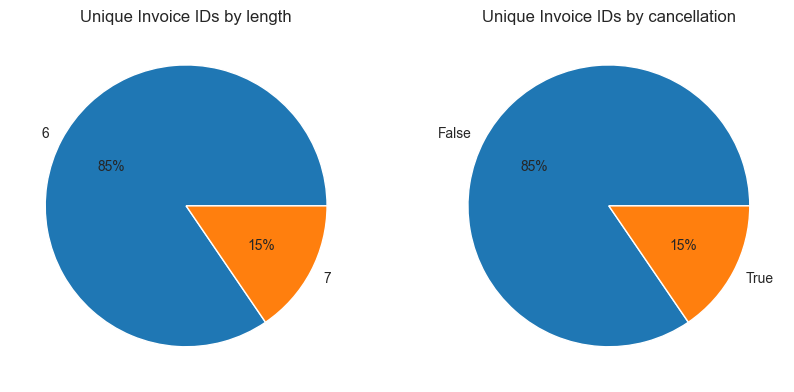

In [6]:
# Let's add a column to quick retrieval of cancelled transactions
df_clean["is_cancelled"]=np.where(df_clean.invoice_id.str.startswith("C"), True, False)

df_clean[['invoice_id']].describe()

df_temp = df_clean.assign(len_invoice =df_clean['invoice_id'].str.len() )
df_temp = df_temp[['invoice_id','is_cancelled','len_invoice']].drop_duplicates()

df_temp[df_temp.is_cancelled == True]['invoice_id'].unique()


fig, axes = plt.subplots(1, 2, figsize=(10,10))
axes[0].pie(df_temp.groupby(by = 'len_invoice')['invoice_id'].count(), labels= df_temp['len_invoice'].drop_duplicates(), autopct='%.0f%%') 
axes[0].set_title("Unique Invoice IDs by length")

axes[1].pie(df_temp.groupby(by = 'is_cancelled')['invoice_id'].count(), labels= df_temp['is_cancelled'].drop_duplicates(), autopct='%.0f%%') 
axes[1].set_title("Unique Invoice IDs by cancellation")




From the above, it seems all and only the cancelled transactions have length = 7. Unfortunately, this is not true due to some bad transactions with very odd values. Let's get rid of them

In [7]:
valid_odd_trans = df_temp[(df_temp.is_cancelled == False) & (df_temp.len_invoice == 7)]['invoice_id']
print(f"Is it true that all and only the cancelled transactions have length = 7? {valid_odd_trans.empty}")

df_clean[df_clean.invoice_id.isin(valid_odd_trans)]


df_clean = df_clean[~df_clean.invoice_id.isin(valid_odd_trans)]

Is it true that all and only the cancelled transactions have length = 7? False


invoice_id stock_code      description  qty   invoice_timestamp  \
179403    A506401          B  adjust bad debt    1 2010-04-29 13:36:00   
276274    A516228          B  adjust bad debt    1 2010-07-19 11:24:00   
403472    A528059          B  adjust bad debt    1 2010-10-20 12:04:00   
825443    A563185          B  adjust bad debt    1 2011-08-12 14:50:00   
825444    A563186          B  adjust bad debt    1 2011-08-12 14:51:00   
825445    A563187          B  adjust bad debt    1 2011-08-12 14:52:00   

          unit_price customer_id         country invoice_date  invoice_day  \
179403 -53594.359375         NaN  United Kingdom   2010-04-29           29   
276274 -44031.789062         NaN  United Kingdom   2010-07-19           19   
403472 -38925.871094         NaN  United Kingdom   2010-10-20           20   
825443  11062.059570         NaN  United Kingdom   2011-08-12           12   
825444 -11062.059570         NaN  United Kingdom   2011-08-12           12   
825445 -11062.059570         NaN  United Kingdom   2011-08-12           12   

       invoice_day_name  invoice_week  invoice_month  invoice_quarter  \
179403         Thursday            17              4                2   
276274           Monday            29              7                3   
403472        Wednesday            42             10                4   
825443           Friday            32              8                3   
825444           Friday            32              8                3   
825445           Friday            32              8                3   

        invoice_year  is_cancelled  
179403          2010         False  
276274          2010         False  
403472          2010         False  
825443          2011         False  
825444          2011         False  
825445          2011         False

Noe let's focus on the *cancelled transactions*. They are associated to negative qty values only. Moreover, it seems that for some cancelled transactions there exists a valid transaction (probably a mistake). Clearly, due to the time horizon we are managing, it's qui infeasible to retrieve all the valid transaction associated to a cancelled transaction. For the moment, let's try this matching and let's get rid of them.



In [8]:
df_clean[df_clean['is_cancelled'] == True][['unit_price', 'qty']].describe()

unit_price           qty
count  19104.000000  19104.000000
mean      42.849239    -24.959119
std      574.810730    810.409329
min        0.010000 -80995.000000
25%        1.450000     -6.000000
50%        2.950000     -2.000000
75%        6.650000     -1.000000
max    38970.000000      1.000000

In [9]:
def find_first_matching_transaction(df: pd.DataFrame) -> pd.DataFrame:
    """
    Find the first matching non-cancelled transaction for each cancelled transaction in the DataFrame.
    
    This function searches for matching transactions where:
      - `stock_code` and `customer_id` are the same.
      - The `qty` in the non-cancelled transaction is the opposite (negated) of the cancelled transaction's `qty`.
    
    The function returns the original DataFrame with rows removed that represent pairs of matched transactions.
    
    Args:
        df (pd.DataFrame): The input DataFrame containing transaction data. 
                           Must include columns: 'stock_code', 'customer_id', 'qty', 'is_cancelled', and 'invoice_id'.
    
    Returns:
        pd.DataFrame: The DataFrame with matched (cancelled and non-cancelled) transaction rows removed.
    """
    # Create a copy of the DataFrame to avoid modifying the original
    df = df.copy()
    
    # Reset the index to have a unique identifier for each row
    df_temp = df.copy()
    df_temp = df_temp.reset_index()

    # Create a unique transaction ID by concatenating stock_code, customer_id, and qty
    df_temp['transaction_id'] = df_temp['stock_code'] + '_' + df_temp['customer_id'].astype(str) + '_' + df_temp['qty'].astype(str)
    
    # Separate cancelled and non-cancelled transactions
    cancelled = df_temp[df_temp['is_cancelled'] == True]
    non_cancelled = df_temp[df_temp['is_cancelled'] == False]
    
    # Create a 'match_id' in the cancelled transactions where the qty is negated (for matching opposite quantities)
    cancelled['match_id'] = cancelled['stock_code'] + '_' + cancelled['customer_id'].astype(str) + '_' + (-cancelled['qty']).astype(str)
    
    # Merge the cancelled transactions with non-cancelled ones based on matching stock_code, customer_id, and opposite qty
    matches = pd.merge(
        cancelled[['invoice_id', 'stock_code', 'customer_id', 'qty', 'match_id', 'index']],
        non_cancelled[['invoice_id', 'transaction_id', 'index']],
        left_on='match_id',
        right_on='transaction_id',
        how='inner'
    )
    
    # Rename the columns of the resulting DataFrame to make the matching process clearer
    matches.columns = ['cancelled_invoice', 'stock_code', 'customer_id', 'qty', 'match_id', 'cancelled_index', 'matching_invoice', 'transaction_id', 'match_index']


    # Group by the cancelled index to ensure we get the first matching transaction for each cancelled transaction
    matches = matches.groupby('cancelled_index', as_index=False).first()

    
    # Combine the indices of both the cancelled and matching transactions
    lst_index = matches['cancelled_index'].tolist() + matches['match_index'].tolist()
    
    
    
    n = df.shape[0]
    df = df[~df.index.isin(lst_index)]
    
    print(f"Number of matching: {matches.shape[0]}")
    print(f"Number of dropped records: {n - df.shape[0]}")
    return df




In [10]:
df_clean = find_first_matching_transaction(df_clean)



Number of matching: 8084
Number of dropped records: 15175


Let's drop all the other cancelled orders since it's infeasible to understand deeply where they come from.

In [11]:
df_clean = df_clean[df_clean['is_cancelled'] == False]

df_clean[['unit_price','qty']].describe()

unit_price           qty
count  1.006835e+06  1.006835e+06
mean   3.947767e+00  1.041131e+01
std    4.388398e+01  8.097393e+01
min    0.000000e+00 -9.600000e+03
25%    1.250000e+00  1.000000e+00
50%    2.100000e+00  3.000000e+00
75%    4.130000e+00  1.200000e+01
max    2.511109e+04  1.915200e+04

### Stock Code

StockCode: Product (item) code. Nominal. A 5-digit integral number uniquely assigned to each distinct product. 

However, we found very odd and non-5-digit codes for these fields. Another suggestion that something is going wrong during the process of data ingestion in the data warehouse (or whatever it is).


- POST: it seems related to postage spent
- D: discount. Most of them are related to cancellation. They are affecting the sales, but we are speaking  less than 200 rows. Moreover they are not directly related to physical item
- DOT: as POST it seems related to postage spent
- M/m: not clear what they are, it's infeasible to understand whether they are products
- C2: carriage, not clear
- BANK CHARGES: self-explanatory. No physical item. Let's drop them
- TEST: test item. Not useful for our analysis
- PADS: products for pillows. Physical products
- DCGS*: products for military purpose (?). Let's keep them
- ADJUST: probably manual adjustments of some transaction. However it's infeasible to retrieve the original transaction. Less than 70 rows. Let's drop them
- GIFT/gifts*: voucher-related stuff. Let's suppose they are not physical hence there is no inventory issue here. Let's drop them
- S: samples
- B: few and really strange records with incredible high values of price. Let's drop them
- C3: 1 record. Let's drop it
- AMAZON FEE: self-explanatory. No physical item. Let's drop them
- CRUCK: all these records hold to the same customer. Let's drop them
- P1: not clear. Let's drop them


That's not all the story. There are probably identical stock code that differs only for the upper/lower cases

In [12]:
def find_odd_code(df: pd.DataFrame)->set:

    spec_list=[]
    for code in df.stock_code:
        x=re.findall(r"^\w{1}$|\D[A-Z]+\D|[A-Z]\d|\D[a-z]", code)
        if x not in spec_list:
            if len(x) >0 :
                spec_list.append(x)
        
    return [item for sublist in spec_list for item in sublist]

find_odd_code(df_clean)

['POST',
 'DCGS',
 'DOT',
 'bl',
 'C2',
 'M',
 'BANK ',
 'CHARGES',
 'TEST',
 'gi',
 'ft',
 'PADS',
 'ADJUST',
 'DCGSSGIRL',
 'GIFT',
 'DCGSLBOY',
 'm',
 'DCGSSBOY',
 'DCGSLGIRL',
 'D',
 'C3',
 'P1',
 'AMAZONFEE',
 'S']

In [13]:
n = df_clean.shape[0]
df_clean = df_clean[~df_clean['stock_code'].str.startswith(tuple(find_odd_code(df_clean)))]

print(f"We remove {n -df_clean.shape[0]} records")

We remove 4627 records


After this cleaning we still have some len=7 codes. However they seem related to real items. Let's keep them.

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='stock_len', ylabel='count'>

<Axes: xlabel='is_digit', ylabel='count'>

<Figure size 640x480 with 0 Axes>

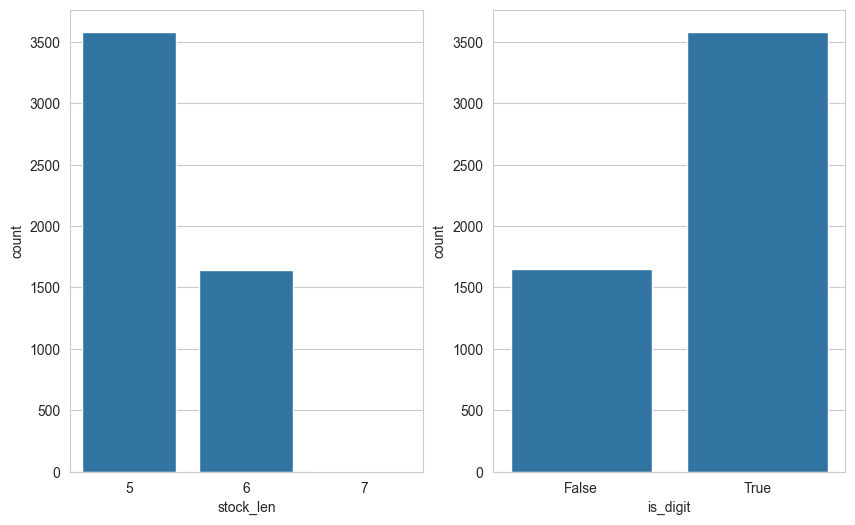

In [14]:
df_temp = df_clean[['stock_code']].drop_duplicates()
df_temp['stock_len'] =df_temp['stock_code'].str.len()
df_temp['is_digit'] = df_temp['stock_code'].str.isdigit()

plt.figure()

fig, axes = plt.subplots(1,2, figsize= (10,6))
sns.barplot(data = df_temp['stock_len'].value_counts(), ax = axes[0])

sns.barplot(data = df_temp['is_digit'].value_counts(), ax = axes[1])

df_clean['stock_code'] = df_clean['stock_code'].str.upper()

Finally, it's worth noting that for the very same stock code, there are multiple descriptions. Again, something went wrong during the collection phase. Let's handle this case in the following steps

Last but not least, let's plot the number of different stock code ordered day by day and month by month

<Axes: xlabel='invoice_date'>

<Axes: xlabel='invoice_year,invoice_month'>

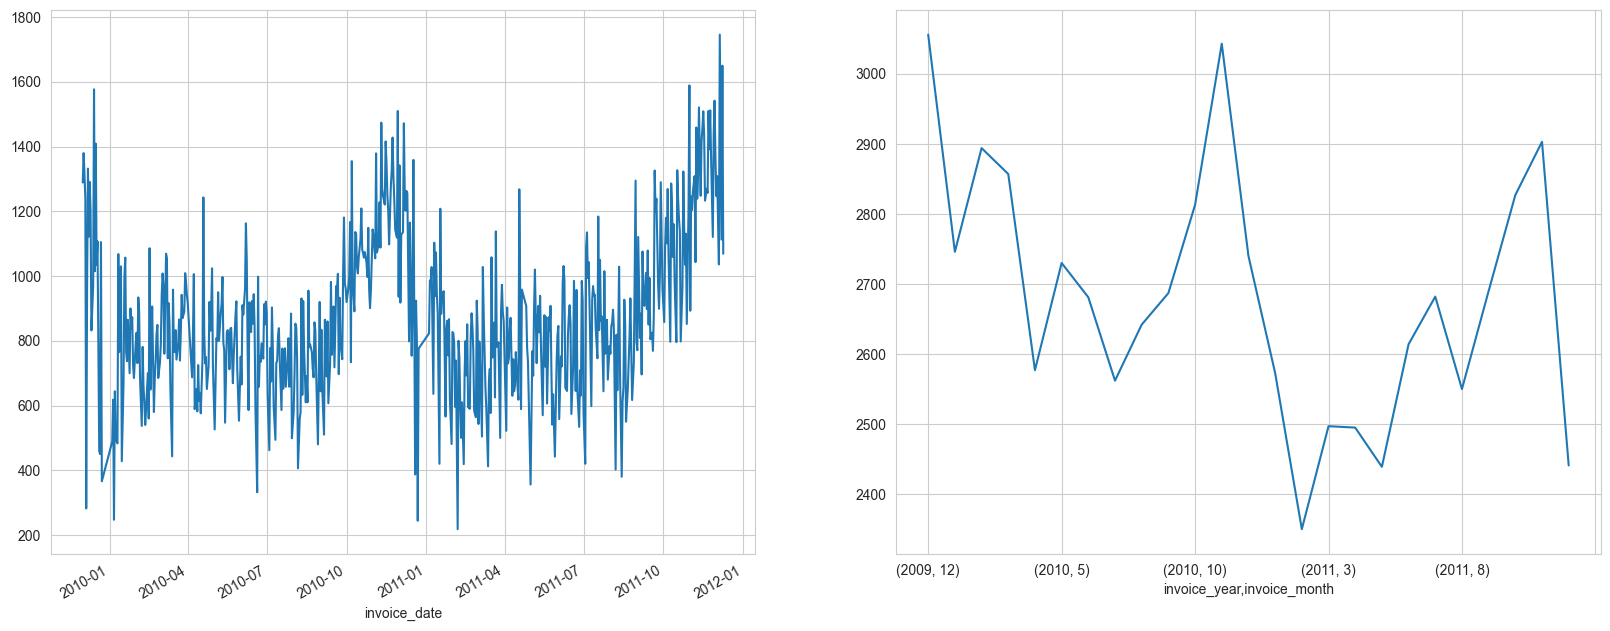

In [15]:
fig, axes = plt.subplots(1,2, figsize=(20,8))

df_clean.groupby(by = 'invoice_date')['stock_code'].nunique().plot(ax=axes[0])
df_clean.groupby(by = ['invoice_year','invoice_month'])['stock_code'].nunique().plot(ax=axes[1])


### Description

Description: Product (item) name. Nominal. Due to this, then there should be a 1:1 correspondence between stock and description. However this is not the case. Moreover, this is one of the column that shows NaNs

**Why do we have some stock code having more than one description?**

**Why do we have NaNs description? Is it possible to replace them? Are there fake NaNs hidden this field?Are there relations with other columns?**

However, this field could be not so useful for our analysis. One of the possible path we can follow is creating higher level product category based on the name. By now, let's perform some quick and dirty adjustments

In [16]:
df_clean[['description']].describe()

print("NaNs values")
df_clean[['description']].isnull().sum()

description
count                               997998
unique                                5564
top     white hanging heart t-light holder
freq                                  5569

NaNs values


description    4210
dtype: int64

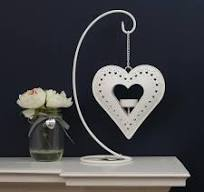

Let's replace the description of each stock code with  the most frequent description. This will help us to substitute also some NaNs

In [17]:
df_temp = df_clean.groupby(by = 'stock_code', as_index=False)['description'].nunique()
lst_multiple_desc = df_temp[df_temp['description'] >1]['stock_code'].unique().tolist()


dict_replace_description = (df_clean[df_clean['stock_code'].isin(lst_multiple_desc)]
            .groupby(by = 'stock_code', as_index=False)['description']
            .agg(lambda x: pd.Series.mode(x)[0])
            .set_index('stock_code')['description']
            .to_dict()
            
)
df_clean = df_clean.assign(description=df_clean.stock_code.map(dict_replace_description).fillna(df_clean.description))

print("NaNs values")
df_clean[['description']].isnull().sum()

NaNs values


description    3286
dtype: int64

In [18]:
print(f"Is it True that now each stock code has unique description? {df_clean.groupby(by = 'stock_code')['description'].nunique().le(1).all()}")

Is it True that now each stock code has unique description? True


Are there other NaNs? Like string with "nan", "", " "? No

In [19]:
df_clean[df_clean.description.isin(['nan','NaN','NAN','NA','',' '])].empty

True

Are there relations with other columns? Yes, each NaN has zero qty, moreover, all the NaNs here have NaN as customer id as well. Let's drop the NaNs then

In [20]:
print("Has all the NaNs in description also have NaNs in customer_id?", all(df_clean[df_clean.description.isna()].customer_id))

print("Has all the NaNs in description have zero price?", all(df_clean[df_clean.description.isna()]['unit_price'] == 0))

df_clean = df_clean[~df_clean.description.isna()]

Has all the NaNs in description also have NaNs in customer_id? True
Has all the NaNs in description have zero price? True


What about strange descriptions? Like very short descriptions. We have lost/damanges/missing stuff. Let's get rif of them

In [21]:
df_clean = df_clean[~(df_clean['description'].str.len() <=7)]

There are still more stock codes than description. This mean there is at least one description with several stock codes. This could be ok since the description may not intercept all the features of the item

In [22]:
df_clean[['description']].describe()

df_clean[['stock_code']].describe()

description
count                               998911
unique                                4671
top     white hanging heart t-light holder
freq                                  5581

stock_code
count      998911
unique       4709
top        85123A
freq         5581

### Quantity

Quantity: The quantities of each product (item) per transaction. Numeric.
Despite we already dropped cancelled transactions where qty <0 is reasonable. We still face some negative qtys. Another suggestion that most of these data are corrupts or not well captured by the system. Definitely, PD have to deal with these issues once for all

qty
count  998911.000000
mean       10.550663
std        76.695310
min     -9600.000000
25%         1.000000
50%         4.000000
75%        12.000000
max     19152.000000

<Axes: xlabel='qty', ylabel='Count'>

Text(0.5, 1.0, 'qty distribution')

<Axes: xlabel='qty', ylabel='Count'>

Text(0.5, 1.0, 'Log-qty distribution')

Text(0.5, 0, 'Natural-Log qty')

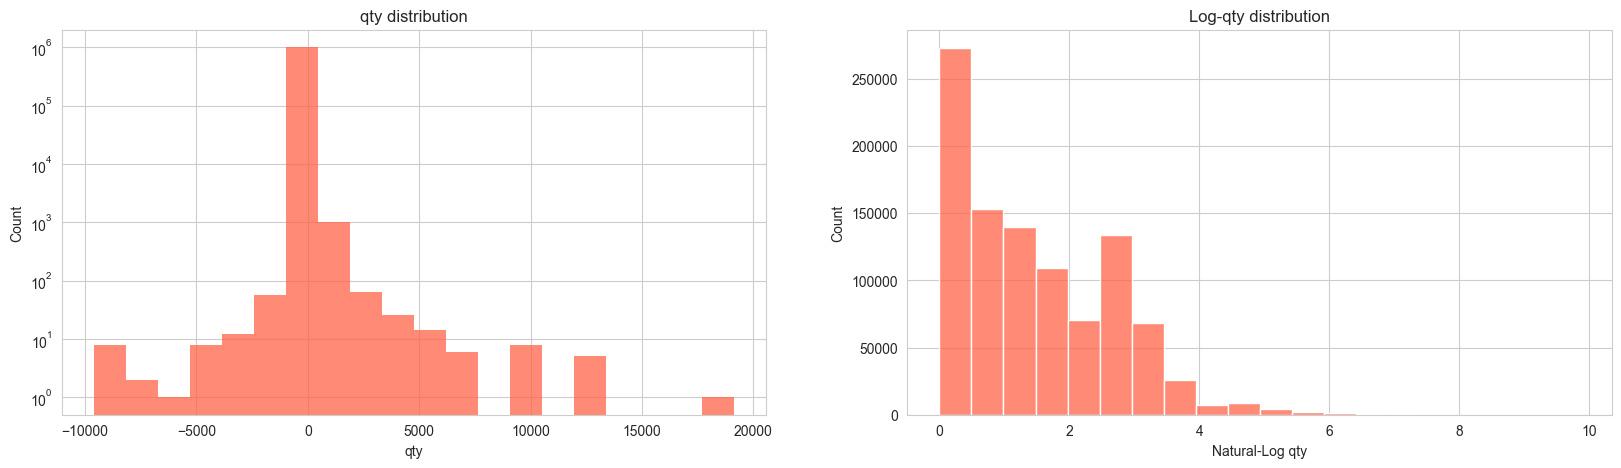

In [23]:
df_clean[['qty']].describe()

fig, ax = plt.subplots(1, 2, figsize=(20, 5))

# Plotting qty distribution
sns.histplot(df_clean.qty, ax=ax[0], bins=20, color="tomato", log_scale=(False, True))
ax[0].set_title("qty distribution")
ax[0].set_yscale("log")  # Ensure the y-axis is log-scaled

# Plotting log-transformed qty distribution
sns.histplot(np.log(df_clean.qty), ax=ax[1], bins=20, color="tomato")
ax[1].set_title("Log-qty distribution")
ax[1].set_xlabel("Natural-Log qty")

Clearly there is something wrong here. If the quantity is negative, then customer = NaN and price = 0. Let's get rid of these records

In [24]:
print("Has all the qty < 0 in qty have NaNs in customer_id?", all(df_clean[df_clean.qty.isna()].customer_id))

print("Has all the qty < 0 in qty have zero price?", all(df_clean[df_clean.qty.isna()]['unit_price'] == 0))

Has all the qty < 0 in qty have NaNs in customer_id? True
Has all the qty < 0 in qty have zero price? True


qty
count  997729.000000
mean       10.938792
std        67.931007
min         1.000000
25%         1.000000
50%         4.000000
75%        12.000000
max     19152.000000

qty  unit_price
0.0000     1.0    0.000000
0.0500     1.0    0.420000
0.9500    31.0    9.950000
0.9800    72.0   12.750000
0.9900   101.0   16.950001
0.9990   480.0   34.040001
0.9999  2400.0  125.000000

<Axes: xlabel='qty', ylabel='Count'>

Text(0.5, 1.0, 'qty distribution')

<Axes: xlabel='qty', ylabel='Count'>

Text(0.5, 1.0, 'Log-qty distribution')

Text(0.5, 0, 'Natural-Log qty')

<Axes: ylabel='qty'>

Text(0.5, 1.0, 'qty distribution')

<Axes: ylabel='qty'>

Text(0.5, 1.0, 'Log-qty distribution')

Text(0.5, 0, 'Natural-Log qty')

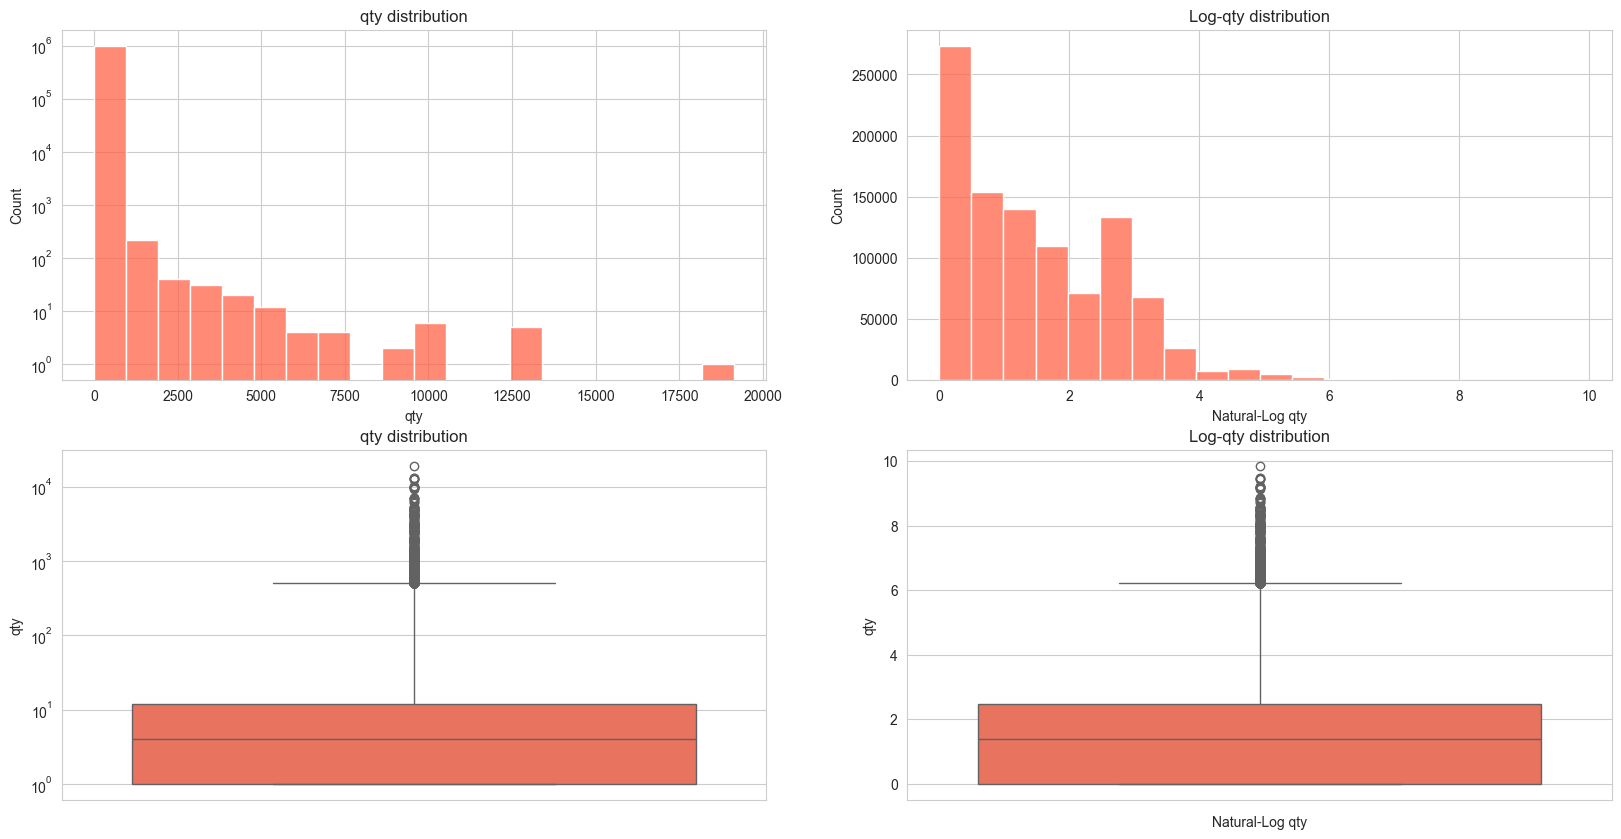

In [25]:
df_clean = df_clean[df_clean['qty'] > 0]

df_clean[['qty']].describe()


df_clean[['qty','unit_price']].quantile([0,0.05, 0.95, 0.98, 0.99, 0.999, 0.9999])

fig, ax = plt.subplots(2, 2, figsize=(20, 10))

# Plotting qty distribution
sns.histplot(df_clean.qty, ax=ax[0][0], bins=20, color="tomato", log_scale=(False, True))
ax[0][0].set_title("qty distribution")
ax[0][0].set_yscale("log")  # Ensure the y-axis is log-scaled

# Plotting log-transformed qty distribution
sns.histplot(np.log(df_clean.qty), ax=ax[0][1], bins=20, color="tomato")
ax[0][1].set_title("Log-qty distribution")
ax[0][1].set_xlabel("Natural-Log qty")



# Plotting qty distribution
sns.boxplot(df_clean.qty, ax=ax[1][0], color="tomato", log_scale=(False, True))
ax[1][0].set_title("qty distribution")
ax[1][0].set_yscale("log")  # Ensure the y-axis is log-scaled

# Plotting log-transformed qty distribution
sns.boxplot(np.log(df_clean.qty), ax=ax[1][1], color="tomato")
ax[1][1].set_title("Log-qty distribution")
ax[1][1].set_xlabel("Natural-Log qty")




There are still tons of outliers (likely outliers actually). However, we we drop them it's likely to still have again the 99,9% of the data. However, we have to be careful here since the analysis main focus of items with high revenue (i.e. items with high price as well as price*qty). So we have to deeply understand whether the outliers here are errors or not

In [26]:
#plt.figure(figsize=(18,6))
#sns.scatterplot(data = df_clean, x=df_clean.index, y=df_clean['qty']) #ci mette una vita a runnare...

We can notice that the qty associated to items as "pack of 12 woodland tissues" are really divisible by that number (i.e. 12 in this example). They seems reasonable to me. However, there are transactions with the very same stock code... with <12 as qty. How to handle such odd cases?
- An item is a pack of something, hence it's ok considering this as a unique item and not 12 separated items
- We have to understand whether the unit price is for the pack or only for a single unit of the pack

Since it's not easy to deal with this behavior, let's tried to get rid of them

In [27]:
df_clean[df_clean.qty >= df_clean.qty.quantile(0.999)]

invoice_id stock_code                          description   qty  \
217         489460      84598        boys alphabet iron on patches   576   
575         489523      84879        assorted colour bird ornament   800   
4793        489831      84347  rotating silver angels t-light hldr   480   
6443        489889     85123A   white hanging heart t-light holder   480   
6555        489898     79323G                  gold  cherry lights   954   
...            ...        ...                                  ...   ...   
1060413     581175      23084                   rabbit night light  1440   
1063344     581375      21137             black record cover frame   960   
1065522     581457      23543                   wall art keep calm   698   
1065531     581458      22197                 small popcorn holder  1500   
1065532     581459      22197                 small popcorn holder  1200   

          invoice_timestamp  unit_price customer_id         country  \
217     2009-12-01 10:46:00        0.21       16167  United Kingdom   
575     2009-12-01 11:46:00        1.45       12931  United Kingdom   
4793    2009-12-02 13:58:00        2.10       12435         Denmark   
6443    2009-12-02 16:52:00        2.55       14646     Netherlands   
6555    2009-12-03 09:40:00        0.00         NaN  United Kingdom   
...                     ...         ...         ...             ...   
1060413 2011-12-07 15:16:00        1.79       14646     Netherlands   
1063344 2011-12-08 12:36:00        3.39       16210  United Kingdom   
1065522 2011-12-08 18:43:00        4.15       18102  United Kingdom   
1065531 2011-12-08 18:45:00        0.72       17949  United Kingdom   
1065532 2011-12-08 18:46:00        0.72       17949  United Kingdom   

        invoice_date  invoice_day invoice_day_name  invoice_week  \
217       2009-12-01            1          Tuesday            49   
575       2009-12-01            1          Tuesday            49   
4793      2009-12-02            2        Wednesday            49   
6443      2009-12-02            2        Wednesday            49   
6555      2009-12-03            3         Thursday            49   
...              ...          ...              ...           ...   
1060413   2011-12-07            7        Wednesday            49   
1063344   2011-12-08            8         Thursday            49   
1065522   2011-12-08            8         Thursday            49   
1065531   2011-12-08            8         Thursday            49   
1065532   2011-12-08            8         Thursday            49   

         invoice_month  invoice_quarter  invoice_year  is_cancelled  
217                 12                4          2009         False  
575                 12                4          2009         False  
4793                12                4          2009         False  
6443                12                4          2009         False  
6555                12                4          2009         False  
...                ...              ...           ...           ...  
1060413             12                4          2011         False  
1063344             12                4          2011         False  
1065522             12                4          2011         False  
1065531             12                4          2011         False  
1065532             12                4          2011         False  

[1144 rows x 16 columns]

In [28]:
df_clean[df_clean.stock_code == '35004B']['unit_price'].unique()

array([ 4.65, 13.  ,  5.45,  1.95,  6.04,  5.91, 12.72, 12.46,  5.79],
      dtype=float32)

In [29]:
df_temp = df_clean[df_clean.description.str.startswith(('set of', 'pack of'))]

print(f"'Set of' and 'Pack of' items are {df_temp.shape[0] / df_clean.shape[0]:.1f}% of the total records")

df_clean = df_clean[~(df_clean.description.str.startswith(('set of', 'pack of')))]

'Set of' and 'Pack of' items are 0.1% of the total records


In [30]:
df_clean[['qty']].describe()


df_clean[['qty','unit_price']].quantile([0,0.05, 0.95, 0.98, 0.99, 0.999, 0.9999])

qty
count  932072.000000
mean       10.663395
std        63.981680
min         1.000000
25%         1.000000
50%         3.000000
75%        10.000000
max     19152.000000

qty  unit_price
0.0000     1.0    0.000000
0.0500     1.0    0.420000
0.9500    30.0    9.950000
0.9800    72.0   13.570000
0.9900   100.0   16.950001
0.9990   480.0   34.950001
0.9999  2000.0  125.000000

In [31]:
df_clean.iloc[df_clean.qty.argmax()]

invoice_id                                       497946
stock_code                                        37410
description          black and white paisley flower mug
qty                                               19152
invoice_timestamp                   2010-02-15 11:57:00
unit_price                                          0.1
customer_id                                       13902
country                                         Denmark
invoice_date                        2010-02-15 00:00:00
invoice_day                                          15
invoice_day_name                                 Monday
invoice_week                                          7
invoice_month                                         2
invoice_quarter                                       1
invoice_year                                       2010
is_cancelled                                      False
Name: 90857, dtype: object

The very same customer bought two times this item... and tons of pieces... These could be valid transactions. However they are random and could make our analysis dirty.

In [32]:
df[(df.stock_code == '37410')]

invoice_id stock_code                         description    qty  \
951        489542      37410  black and white paisley flower mug    216   
2545       489601      37410  black and white paisley flower mug      1   
14883      490625      37410  black and white paisley flower mug     12   
18310      490938      37410  black and white paisley flower mug     12   
18949      490963      37410  black and white paisley flower mug      1   
20052      491041      37410  black and white paisley flower mug      1   
22196      491148      37410  black and white paisley flower mug     72   
27645      491713      37410  black and white paisley flower mug     12   
30911      491969      37410  black and white paisley flower mug      1   
31496      491970      37410  black and white paisley flower mug      1   
34327      492250      37410  black and white paisley flower mug     12   
37064      492425      37410  black and white paisley flower mug      1   
41106      492783      37410  black and white paisley flower mug      1   
43123      493074      37410  black and white paisley flower mug      1   
44362      493269      37410  black and white paisley flower mug      1   
44438      493273      37410  black and white paisley flower mug      1   
47658      493825      37410  black and white paisley flower mug     12   
56056      494443      37410  black and white paisley flower mug      1   
59043      494676      37410  black and white paisley flower mug      4   
65077      495194      37410  black and white paisley flower mug   6012   
67445      495370      37410  black and white paisley flower mug      6   
67486     C495373      37410  black and white paisley flower mug     -6   
68353      495406      37410  black and white paisley flower mug      3   
75072      496247      37410  black and white paisley flower mug      6   
90857      497946      37410  black and white paisley flower mug  19152   
93123      498133      37410  black and white paisley flower mug      1   
97269      498548      37410  black and white paisley flower mug     12   
104920     499456      37410  black and white paisley flower mug     12   
105475     499486      37410  black and white paisley flower mug     72   
106272     499518      37410                             damages   -355   
106309     499522      37410                                 NaN     36   
124108     501264      37410  black and white paisley flower mug     12   
127816     501558      37410  black and white paisley flower mug      1   
133034     502030      37410  black and white paisley flower mug      1   
133339     502055      37410  black and white paisley flower mug      6   
151295     503806      37410  black and white paisley flower mug     48   
151396     503817      37410                                 NaN    -55   

         invoice_timestamp  unit_price customer_id         country  \
951    2009-12-01 12:19:00    0.850000       15061  United Kingdom   
2545   2009-12-01 14:44:00   16.480000         NaN  United Kingdom   
14883  2009-12-07 11:55:00    1.250000       14543  United Kingdom   
18310  2009-12-08 13:59:00    1.250000       14605  United Kingdom   
18949  2009-12-08 15:49:00   16.480000         NaN  United Kingdom   
20052  2009-12-09 09:42:00   16.480000         NaN  United Kingdom   
22196  2009-12-10 07:43:00    1.060000       15061  United Kingdom   
27645  2009-12-13 15:24:00    1.250000       17819  United Kingdom   
30911  2009-12-14 17:57:00   16.480000         NaN  United Kingdom   
31496  2009-12-14 18:03:00   16.480000         NaN  United Kingdom   
34327  2009-12-16 10:45:00    1.250000       18286  United Kingdom   
37064  2009-12-16 17:58:00   16.480000         NaN  United Kingdom   
41106  2009-12-18 17:15:00   16.480000         NaN  United Kingdom   
43123  2009-12-22 09:45:00   16.480000         NaN  United Kingdom   
44362  2009-12-22 15:07:00   16.480000         NaN  United Kingdom   
44438  2009-12-22 15:09:00   16.4800

For item 84077 it seems reasonable to keep the second-highest values seems the same customer repeat the transactions tons of time (and it's not the only customer). It could be the system is broken for those particular customers, but since there seems there is a path, let's keep the record

However, due to these strange behavior probably we ha to know something better about those customer and probably treat them via MTO (make to order) instead of MTS (as it seems to me here). Hence a very specific treatment

In [33]:
# Create a time series plot

df_filtered = df_clean[df_clean.stock_code == '84077']

df_filtered.sort_values(by = 'qty', ascending=False).head(20)
df_temp = df_filtered.groupby(by = 'invoice_date', as_index=False)['qty'].sum()
fig = px.line(df_temp, x='invoice_date', y='qty', title='Time Series of Quantities Over Time')

# Customize the layout (optional)
fig.update_layout(
    xaxis_title='Invoice Date',
    yaxis_title='Quantity',
    template='plotly_white', 
    width=900,
    height=500
)

invoice_id stock_code                        description   qty  \
947093     573008      84077  world war 2 gliders asstd designs  4800   
432173     530714      84077  world war 2 gliders asstd designs  4320   
507883     536830      84077  world war 2 gliders asstd designs  2880   
380493     526084      84077  world war 2 gliders asstd designs  2880   
606203     543057      84077  world war 2 gliders asstd designs  2592   
292897     517953      84077  world war 2 gliders asstd designs  2304   
124125     501266      84077  world war 2 gliders asstd designs  2016   
680032     549926      84077  world war 2 gliders asstd designs  1728   
326882     521318      84077  world war 2 gliders asstd designs  1440   
442862     531544      84077  world war 2 gliders asstd designs  1200   
694584     551162      84077  world war 2 gliders asstd designs  1200   
149402     503597      84077  world war 2 gliders asstd designs  1152   
196349     508195      84077  world war 2 gliders asstd designs  1152   
695974     551314      84077  world war 2 gliders asstd designs  1152   
668210     548635      84077  world war 2 gliders asstd designs  1152   
229540     511552      84077  world war 2 gliders asstd designs  1152   
668163     548627      84077  world war 2 gliders asstd designs  1152   
733630     555099      84077  world war 2 gliders asstd designs  1152   
634930     545644      84077  world war 2 gliders asstd designs  1152   
691887     550917      84077  world war 2 gliders asstd designs  1008   

         invoice_timestamp  unit_price customer_id         country  \
947093 2011-10-27 12:26:00        0.21       12901  United Kingdom   
432173 2010-11-04 11:35:00        0.18       16754  United Kingdom   
507883 2010-12-02 17:38:00        0.18       16754  United Kingdom   
380493 2010-10-08 12:03:00        0.18       16754  United Kingdom   
606203 2011-02-03 10:50:00        0.21       16333  United Kingdom   
292897 2010-08-03 11:56:00        0.18       16754  United Kingdom   
124125 2010-03-15 12:52:00        0.18       16754  United Kingdom   
680032 2011-04-13 10:14:00        0.21       16333  United Kingdom   
326882 2010-09-03 12:06:00        0.18       16754  United Kingdom   
442862 2010-11-09 07:56:00        0.21       17381  United Kingdom   
694584 2011-04-26 15:45:00        0.21       12901  United Kingdom   
149402 2010-04-06 09:28:00        0.18       16754  United Kingdom   
196349 2010-05-13 13:25:00        0.18       16754  United Kingdom   
695974 2011-04-27 15:07:00        0.21       16333  United Kingdom   
668210 2011-04-01 12:27:00        0.21       16333  United Kingdom   
229540 2010-06-09 09:41:00        0.18       16754  United Kingdom   
668163 2011-04-01 12:19:00        0.21       16333  United Kingdom   
733630 2011-05-31 13:39:00        0.21       16333  United Kingdom   
634930 2011-03-04 12:37:00        0.21       16333  United Kingdom   
691887 2011-04-21 13:40:00        0.21       17381  United Kingdom   

       invoice_date  invoice_day invoice_day_name  invoice_week  \
947093   2011-10-27           27         Thursday            43   
432173   2010-11-04            4         Thursday            44   
507883   2010-12-02            2         Thursday            48   
380493   2010-10-08            8           Friday            40   
606203   2011-02-03            3         Thursday             5   
292897   2010-08-03            3          Tuesday            31   
124125   2010-03-15           15           Monday            11   
680032   2011-04-13           13        Wednesday            15   
326882   2010-09-03            3           Friday            35   
442862   2010-11-09            9          Tuesday            45   
694584   2011-04-26           26          Tuesday            17   
149402   2010-04-06            6          Tuesday            14   
196349   2010-05-13           13         Thursday            19   
695974   2011-04-27           27        Wednesday            17 

Just for fun: for each stock_code, I would like to calculate the probability of a customer_id  to buy the item more than 4 times with qty > average(qty) of that stock_code

In [34]:
# Step 1: Calculate the average qty for each stock_code
average_qty_per_stock_code = df_clean.groupby('stock_code')['qty'].mean().reset_index()
average_qty_per_stock_code.columns = ['stock_code', 'avg_qty']

# Merge the average qty back to the original dataframe
df_clean_merged = pd.merge(df_clean, average_qty_per_stock_code, on='stock_code')



# Step 3: Count how many times each customer_id bought the item more than 4 times with qty > avg_qty
customer_purchase_counts = df_clean_merged.groupby(['customer_id', 'stock_code']).size().reset_index(name='purchase_count')
display(customer_purchase_counts)

# Step 2: Filter for transactions where qty is greater than the average for that stock_code
df_clean_filtered = df_clean_merged[df_clean_merged['qty'] > df_clean_merged['avg_qty']]

customer_purchase_counts_over_avg = df_clean_filtered.groupby(['customer_id', 'stock_code']).size().reset_index(name='purchase_count_over_avg')

display(customer_purchase_counts_over_avg)



customer_tot_count = customer_purchase_counts.merge(customer_purchase_counts_over_avg, on = ['customer_id', 'stock_code'], how='left').fillna(0)
display(customer_tot_count)



# Calculate the probability
customer_tot_count['probability'] = np.where(customer_tot_count['purchase_count'] > 4, customer_tot_count['purchase_count_over_avg'] / customer_tot_count['purchase_count'], 0)

# Output the result
customer_tot_count

customer_id stock_code  purchase_count
0            12346    15056BL               1
1            12346     15056N               1
2            12346     15056P               1
3            12346      20679               1
4            12346      20682               1
...            ...        ...             ...
444513       18287     85040B               1
444514       18287      85041               1
444515       18287      85173               1
444516       18287     85199S               1
444517       18287     85232B               1

[444518 rows x 3 columns]

customer_id stock_code  purchase_count_over_avg
0            12347      20665                        1
1            12347      20716                        1
2            12347      20780                        1
3            12347      20782                        1
4            12347      20966                        2
...            ...        ...                      ...
149882       18287     85040A                        4
149883       18287     85040B                        1
149884       18287      85173                        1
149885       18287     85199S                        1
149886       18287     85232B                        1

[149887 rows x 3 columns]

customer_id stock_code  purchase_count  purchase_count_over_avg
0            12346    15056BL               1                      0.0
1            12346     15056N               1                      0.0
2            12346     15056P               1                      0.0
3            12346      20679               1                      0.0
4            12346      20682               1                      0.0
...            ...        ...             ...                      ...
444513       18287     85040B               1                      1.0
444514       18287      85041               1                      0.0
444515       18287      85173               1                      1.0
444516       18287     85199S               1                      1.0
444517       18287     85232B               1                      1.0

[444518 rows x 4 columns]

customer_id stock_code  purchase_count  purchase_count_over_avg  \
0            12346    15056BL               1                      0.0   
1            12346     15056N               1                      0.0   
2            12346     15056P               1                      0.0   
3            12346      20679               1                      0.0   
4            12346      20682               1                      0.0   
...            ...        ...             ...                      ...   
444513       18287     85040B               1                      1.0   
444514       18287      85041               1                      0.0   
444515       18287      85173               1                      1.0   
444516       18287     85199S               1                      1.0   
444517       18287     85232B               1                      1.0   

        probability  
0               0.0  
1               0.0  
2               0.0  
3               0.0  
4               0.0  
...             ...  
444513          0.0  
444514          0.0  
444515          0.0  
444516          0.0  
444517          0.0  

[444518 rows x 5 columns]

In [35]:
stock = '84077'

customer = '16333'

mask = (customer_tot_count['stock_code'] == stock ) & (customer_tot_count['customer_id'] == customer)

customer_tot_count[mask]

customer_tot_count[customer_tot_count['probability'].between(0.6,0.7)]

customer_id stock_code  purchase_count  purchase_count_over_avg  \
297373       16333      84077               7                      7.0   

        probability  
297373          1.0

customer_id stock_code  purchase_count  purchase_count_over_avg  \
82           12347      22727               5                      3.0   
530          12356      22423               5                      3.0   
2638         12380      21731               5                      3.0   
3342         12393      20726               5                      3.0   
4083         12408      22630               6                      4.0   
...            ...        ...             ...                      ...   
441292       18226      84755               6                      4.0   
441366       18229      22191               5                      3.0   
441439       18230      21181               6                      4.0   
441501       18231      21754               5                      3.0   
443269       18260      22456               5                      3.0   

        probability  
82         0.600000  
530        0.600000  
2638       0.600000  
3342       0.600000  
4083       0.666667  
...             ...  
441292     0.666667  
441366     0.600000  
441439     0.666667  
441501     0.600000  
443269     0.600000  

[812 rows x 5 columns]

For simplicity, let's remove the 0.01% higher

The new max is related to a Christmas item... this item suggest a strong seasonality (high values in the nearby of Christmas). Interesting. This suggest we could aggregate items via similar behavior

In [36]:
df_clean = df_clean[df_clean.qty < df_clean.qty.quantile(0.999)]

df_clean[['qty','unit_price']].describe()

qty     unit_price
count  931075.000000  931075.000000
mean        9.485977       3.396281
std        22.355844       4.719547
min         1.000000       0.000000
25%         1.000000       1.250000
50%         3.000000       2.100000
75%        10.000000       4.150000
max       478.000000    1157.150024

In [37]:
df_clean.iloc[df_clean.qty.argmax()]

df[(df.stock_code == '22086')]

# Create a time series plot

df_filtered = df_clean[df_clean.stock_code == '22086']

df_filtered.sort_values(by = 'qty', ascending=False).head(20)
df_temp = df_filtered.groupby(by = 'invoice_date', as_index=False)['qty'].sum()
fig = px.line(df_temp, x='invoice_date', y='qty', title='Time Series of Quantities Over Time')

# Customize the layout (optional)
fig.update_layout(
    xaxis_title='Invoice Date',
    yaxis_title='Quantity',
    template='plotly_white', 
    width=900,
    height=500
)

invoice_id                                   574941
stock_code                                    22086
description          paper chain kit 50's christmas
qty                                             478
invoice_timestamp               2011-11-07 17:42:00
unit_price                                     6.95
customer_id                                     NaN
country                              United Kingdom
invoice_date                    2011-11-07 00:00:00
invoice_day                                       7
invoice_day_name                             Monday
invoice_week                                     45
invoice_month                                    11
invoice_quarter                                   4
invoice_year                                   2011
is_cancelled                                  False
Name: 972501, dtype: object

invoice_id stock_code                     description  qty  \
151         489446      22086  paper chain kit 50's christmas   12   
303         489488      22086  paper chain kit 50's christmas    5   
325         489505      22086  paper chain kit 50's christmas    6   
402         489519      22086  paper chain kit 50's christmas   12   
465         489520      22086  paper chain kit 50's christmas    6   
...            ...        ...                             ...  ...   
1065701     581473      22086  paper chain kit 50's christmas    3   
1065888     581486      22086  paper chain kit 50's christmas   12   
1066190     581492      22086  paper chain kit 50's christmas   38   
1066845     581498      22086  paper chain kit 50's christmas   52   
1067279     581579      22086  paper chain kit 50's christmas   12   

          invoice_timestamp  unit_price customer_id         country  \
151     2009-12-01 10:06:00        2.95       13758  United Kingdom   
303     2009-12-01 10:59:00        2.95       17238  United Kingdom   
325     2009-12-01 11:17:00        2.95       15712  United Kingdom   
402     2009-12-01 11:37:00        2.95       17700  United Kingdom   
465     2009-12-01 11:41:00        2.95       14911            EIRE   
...                     ...         ...         ...             ...   
1065701 2011-12-08 19:57:00        2.95       12748  United Kingdom   
1065888 2011-12-09 09:38:00        2.95       17001  United Kingdom   
1066190 2011-12-09 10:03:00        5.79         NaN  United Kingdom   
1066845 2011-12-09 10:26:00        5.79         NaN  United Kingdom   
1067279 2011-12-09 12:19:00        2.95       17581  United Kingdom   

        invoice_date  invoice_day invoice_day_name  invoice_week  \
151       2009-12-01            1          Tuesday            49   
303       2009-12-01            1          Tuesday            49   
325       2009-12-01            1          Tuesday            49   
402       2009-12-01            1          Tuesday            49   
465       2009-12-01            1          Tuesday            49   
...              ...          ...              ...           ...   
1065701   2011-12-08            8         Thursday            49   
1065888   2011-12-09            9           Friday            49   
1066190   2011-12-09            9           Friday            49   
1066845   2011-12-09            9           Friday            49   
1067279   2011-12-09            9           Friday            49   

         invoice_month  invoice_quarter  invoice_year  
151                 12                4          2009  
303                 12                4          2009  
325                 12                4          2009  
402                 12                4          2009  
465                 12                4          2009  
...                ...              ...           ...  
1065701             12                4          2011  
1065888             12                4          2011  
1066190             12                4          2011  
1066845             12                4          2011  
1067279             12                4          2011  

[2217 rows x 15 columns]

invoice_id stock_code                     description  qty  \
972501      574941      22086  paper chain kit 50's christmas  478   
3572        489727      22086  paper chain kit 50's christmas  450   
767521      558310      22086  paper chain kit 50's christmas  320   
246529      513264      22086  paper chain kit 50's christmas  300   
487563      534934      22086  paper chain kit 50's christmas  280   
3511        489702      22086  paper chain kit 50's christmas  280   
29849       491953      22086  paper chain kit 50's christmas  240   
926680      571431      22086  paper chain kit 50's christmas  240   
445286      531799      22086  paper chain kit 50's christmas  200   
1013729     577805      22086  paper chain kit 50's christmas  200   
4875        489835      22086  paper chain kit 50's christmas  200   
934         489539      22086  paper chain kit 50's christmas  160   
1017972     578125      22086  paper chain kit 50's christmas  160   
1019338     578252      22086  paper chain kit 50's christmas  160   
912766      570275      22086  paper chain kit 50's christmas  160   
939576      572339      22086  paper chain kit 50's christmas  120   
859973      566259      22086  paper chain kit 50's christmas  120   
3225        489669      22086  paper chain kit 50's christmas  120   
863902      566557      22086  paper chain kit 50's christmas  120   
1007464     577402      22086  paper chain kit 50's christmas  120   

          invoice_timestamp  unit_price customer_id         country  \
972501  2011-11-07 17:42:00        6.95         NaN  United Kingdom   
3572    2009-12-02 11:09:00        2.00       17949  United Kingdom   
767521  2011-06-28 11:20:00        2.55       16671  United Kingdom   
246529  2010-06-23 11:38:00        2.55       17310  United Kingdom   
487563  2010-11-24 15:23:00        2.55       12913  United Kingdom   
3511    2009-12-02 10:52:00        2.55       17511  United Kingdom   
29849   2009-12-14 15:57:00        2.55       15061  United Kingdom   
926680  2011-10-17 12:52:00        2.55       13881  United Kingdom   
445286  2010-11-09 15:39:00        2.55       13093  United Kingdom   
1013729 2011-11-22 08:19:00        2.55       13881  United Kingdom   
4875    2009-12-02 14:15:00        2.55       15061  United Kingdom   
934     2009-12-01 12:18:00        2.55       15061  United Kingdom   
1017972 2011-11-23 10:31:00        2.55       17511  United Kingdom   
1019338 2011-11-23 12:48:00        2.55       16079  United Kingdom   
912766  2011-10-10 10:57:00        2.55       13098  United Kingdom   
939576  2011-10-24 10:32:00        2.55       14607  United Kingdom   
859973  2011-09-11 12:45:00        2.55       17317  United Kingdom   
3225    2009-12-02 08:15:00        2.55       12842  United Kingdom   
863902  2011-09-13 11:47:00        2.55       14646     Netherlands   
1007464 2011-11-20 10:11:00        2.55       15465  United Kingdom   

        invoice_date  invoice_day invoice_day_name  invoice_week  \
972501    2011-11-07            7           Monday            45   
3572      2009-12-02            2        Wednesday            49   
767521    2011-06-28           28          Tuesday            26   
246529    2010-06-23           23        Wednesday            25   
487563    2010-11-24           24        Wednesday            47   
3511      2009-12-02            2        Wednesday            49   
29849     2009-12-14           14           Monday            51   
926680    2011-10-17           17           Monday            42   
445286    2010-11-09            9          Tuesday            45   
1013729   2011-11-22           22          Tuesday            47   
4875      2009-12-02            2        Wednesday            49   
934       2009-12-01            1          Tuesday            49   
1017972   2011-11-23           23        Wednesday            47   
1019338   2011-11-23           23        Wednesday            47   
912766    2011-10-10     

### Date

InvoiceDate: Invice date and time. Numeric. The day and time when a transaction was generated. This column seems ok. Our data starts the 01/12/2009 and end at 09/12/2011. So we have approx 2 years of hystorical data

In [38]:
df_clean[['invoice_date']].describe()

invoice_date
count                         931075
mean   2011-01-01 16:26:06.241172736
min              2009-12-01 00:00:00
25%              2010-07-04 00:00:00
50%              2010-12-07 00:00:00
75%              2011-07-25 00:00:00
max              2011-12-09 00:00:00

In [39]:
# Group by invoice_date and sum qty
qty_per_day = df_clean.groupby("invoice_date")['qty'].sum()

# Calculate 30-day rolling average
rolling_avg = qty_per_day.rolling(window=30, center=True).mean()

# Create the figure
fig = go.Figure();

# Add the actual qty per day plot
fig.add_trace(go.Scatter(
    x=qty_per_day.index, 
    y=qty_per_day.values, 
    mode='lines+markers', 
    marker=dict(symbol='cross', color='darkorange'),
    line=dict(color='darkorange'),
    name='Daily Quantity'
));

# Add the rolling average line
fig.add_trace(go.Scatter(
    x=rolling_avg.index, 
    y=rolling_avg.values, 
    mode='lines',
    line=dict(color='red'),
    name='30-Day Rolling Avg'
))

# Update layout
fig.update_layout(
    title="How many quantities are sold per day over the given time?",
    xaxis_title="Invoice Date",
    yaxis_title="Quantity Sold",
    xaxis=dict(tickangle=90),
    template="plotly_white",  # Optional: cleaner background
    width=1000,
    height=500
)

From below we get some insights:
- Orders almost zero on Saturday
- Most orders are in Tuesday. Wednesday, Thursday
- The pre-Christmas season starts in september and shows a peak in november
- December, January and February and April are the months poor months
- There is a little peak in March

<Axes: xlabel='invoice_day_name'>

<Axes: xlabel='invoice_day_name'>

<Axes: xlabel='invoice_month'>

<Axes: xlabel='invoice_month'>

<Axes: xlabel='invoice_year,invoice_month'>

<Axes: xlabel='invoice_year,invoice_month'>

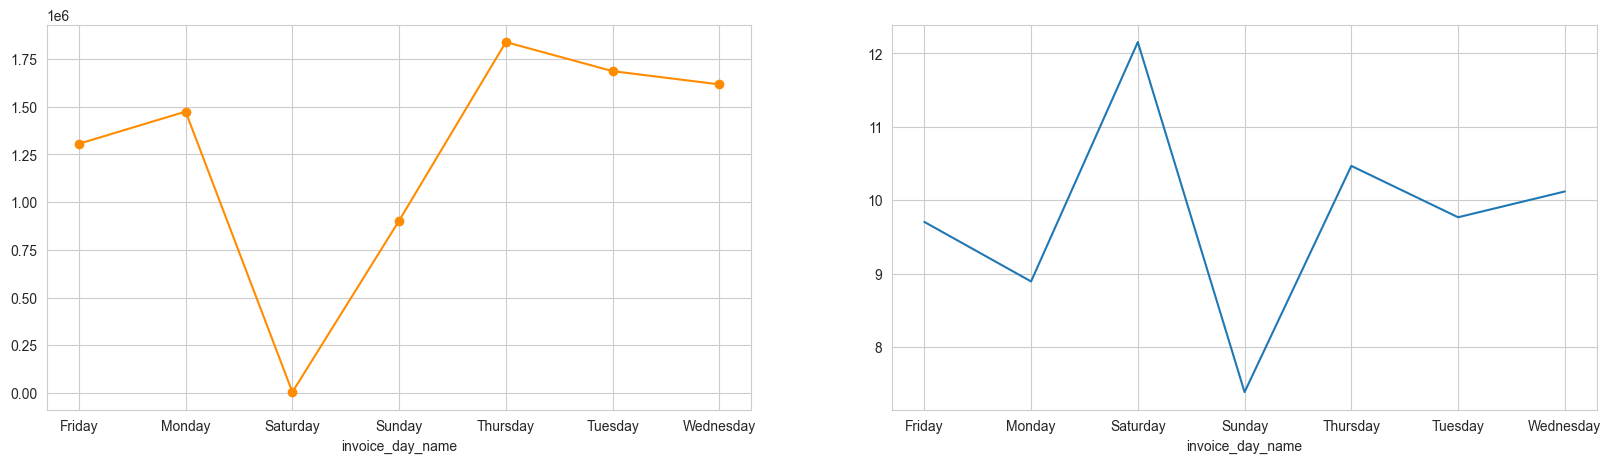

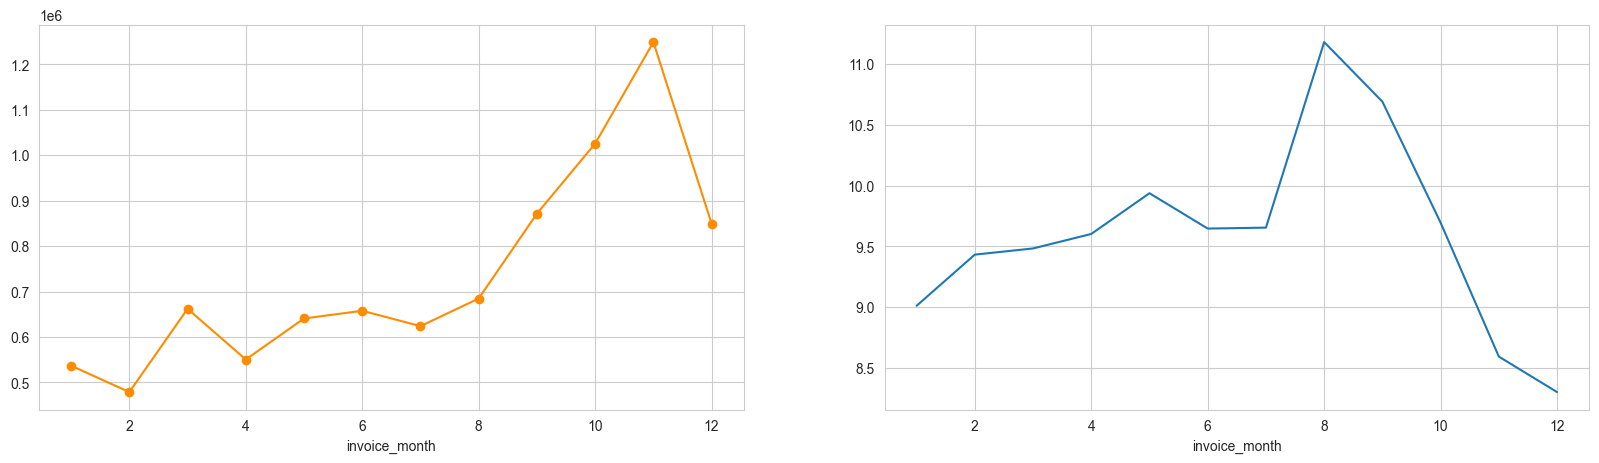

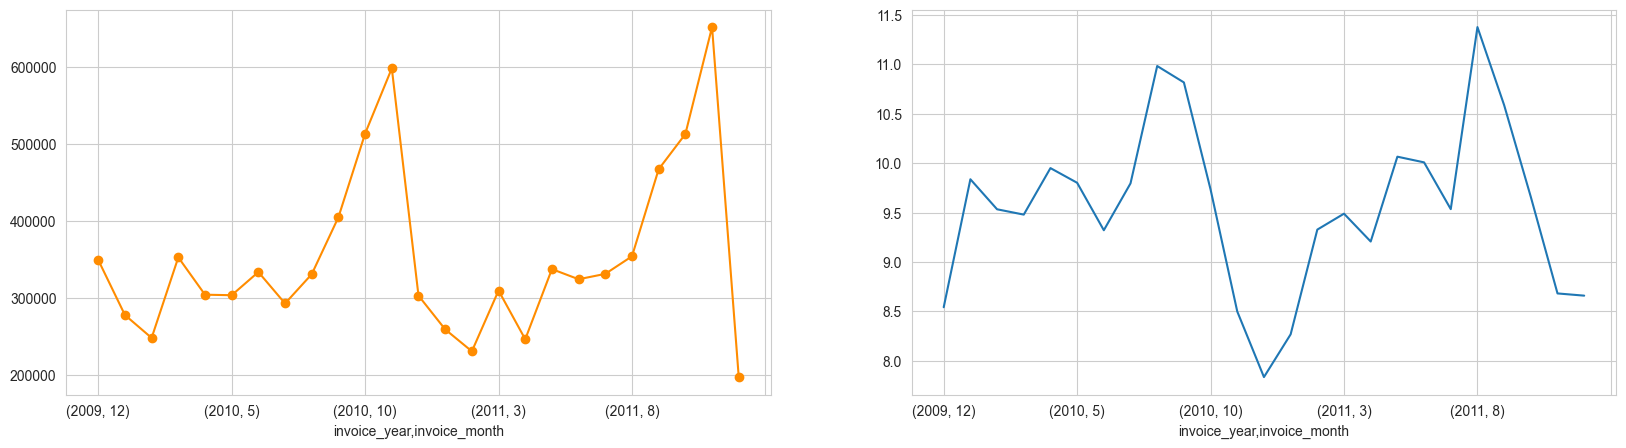

In [40]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
df_clean.groupby(by = 'invoice_day_name')['qty'].sum().plot(ax=ax[0], marker='o', label="Quantity", c="darkorange")
df_clean.groupby(by = 'invoice_day_name')['qty'].mean().plot(ax=ax[1])

fig, ax = plt.subplots(1,2,figsize=(20,5))
df_clean.groupby(by = 'invoice_month')['qty'].sum().plot(ax=ax[0], marker='o', label="Quantity", c="darkorange")
df_clean.groupby(by = 'invoice_month')['qty'].mean().plot(ax=ax[1])


fig, ax = plt.subplots(1,2,figsize=(20,5))
df_clean.groupby(by = ['invoice_year', 'invoice_month'])['qty'].sum().plot(ax=ax[0], marker='o', label="Quantity", c="darkorange")
df_clean.groupby(by = ['invoice_year', 'invoice_month'])['qty'].mean().plot(ax=ax[1])

In [41]:
# Step 1: Identify the top 5 stock_code with the highest unit price
top_5_stock_codes = df_clean.groupby('stock_code')['unit_price'].max().nlargest(5).index

# Step 2: Filter the dataset to include only these top 5 stock_codes
df_top_5 = df_clean[df_clean['stock_code'].isin(top_5_stock_codes)]

# Step 3: Plot the time series for the top 5 stock_code
fig = px.line(df_top_5, x='invoice_date', y='qty', color='stock_code',
              title="Time Series of Quantity Sold for Top 5 Stock Codes by Unit Price",
              labels={"qty": "Quantity Sold", "invoice_date": "Invoice Date", "stock_code": "Stock Code"})

# Customize the layout (optional)
fig.update_layout(
    xaxis_title="Invoice Date",
    yaxis_title="Quantity Sold",
    template="plotly_white",
    width=1000,
    height=600
)

Interesting fact: for a given stock_code, the unit_price change over time


<Figure size 1200x600 with 0 Axes>

<Axes: xlabel='invoice_date', ylabel='unit_price'>

Text(0.5, 1.0, 'Unit Price Over Time for Stock Code 20692')

Text(0.5, 0, 'Invoice Date')

Text(0, 0.5, 'Average Unit Price')

(array([14579., 14610., 14641., 14669., 14700., 14730., 14761., 14791.,
        14822., 14853.]),
 [Text(14579.0, 0, '2009-12'),
  Text(14610.0, 0, '2010-01'),
  Text(14641.0, 0, '2010-02'),
  Text(14669.0, 0, '2010-03'),
  Text(14700.0, 0, '2010-04'),
  Text(14730.0, 0, '2010-05'),
  Text(14761.0, 0, '2010-06'),
  Text(14791.0, 0, '2010-07'),
  Text(14822.0, 0, '2010-08'),
  Text(14853.0, 0, '2010-09')])

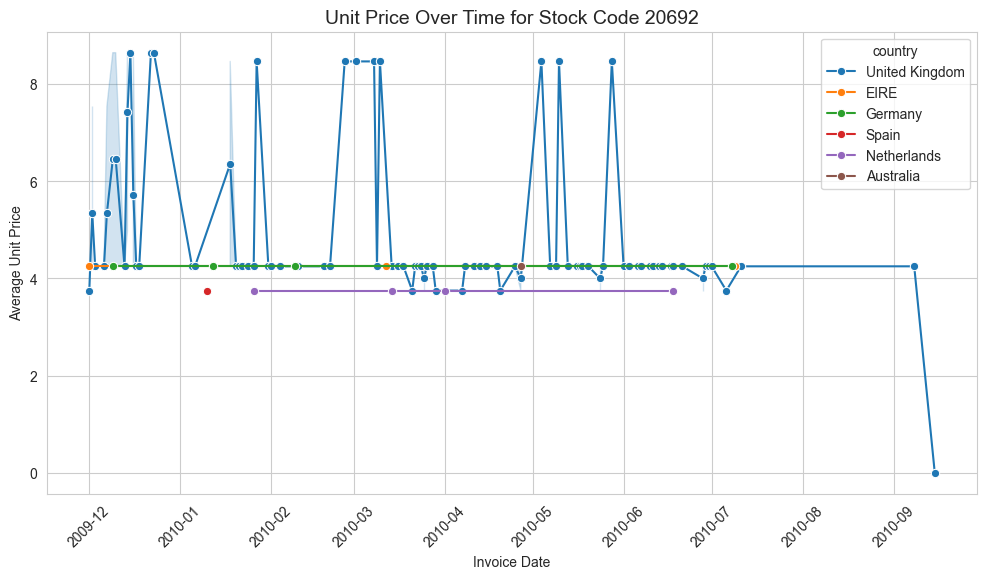

In [42]:
import random

stock_code = random.choice(df_clean['stock_code'].unique())

df_filtered = df_clean[df_clean['stock_code'] == stock_code]

# Ensure the invoice_date is in datetime format
df_filtered['invoice_date'] = pd.to_datetime(df_filtered['invoice_date'])

# Set the plot size
plt.figure(figsize=(12, 6))

# Plot using Seaborn with hue for the country to create separate lines
sns.lineplot(data=df_filtered, x='invoice_date', y='unit_price', hue='country', marker='o')

# Add plot title and labels
plt.title(f'Unit Price Over Time for Stock Code {stock_code}', fontsize=14)
plt.xlabel('Invoice Date')
plt.ylabel('Average Unit Price')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

Let' recap the daily, weekly, monthly qty. As we can see, the week pattern is quite stable, while daily is more a rollercoaster

<Figure size 1400x800 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Daily Quantity Distribution')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Quantity')

<Axes: >

Text(0.5, 1.0, 'Weekly Quantity Distribution')

Text(0.5, 0, 'Week')

Text(0, 0.5, 'Quantity')

<Axes: >

Text(0.5, 1.0, 'Monthly Quantity Distribution')

Text(0.5, 0, 'Month')

Text(0, 0.5, 'Quantity')

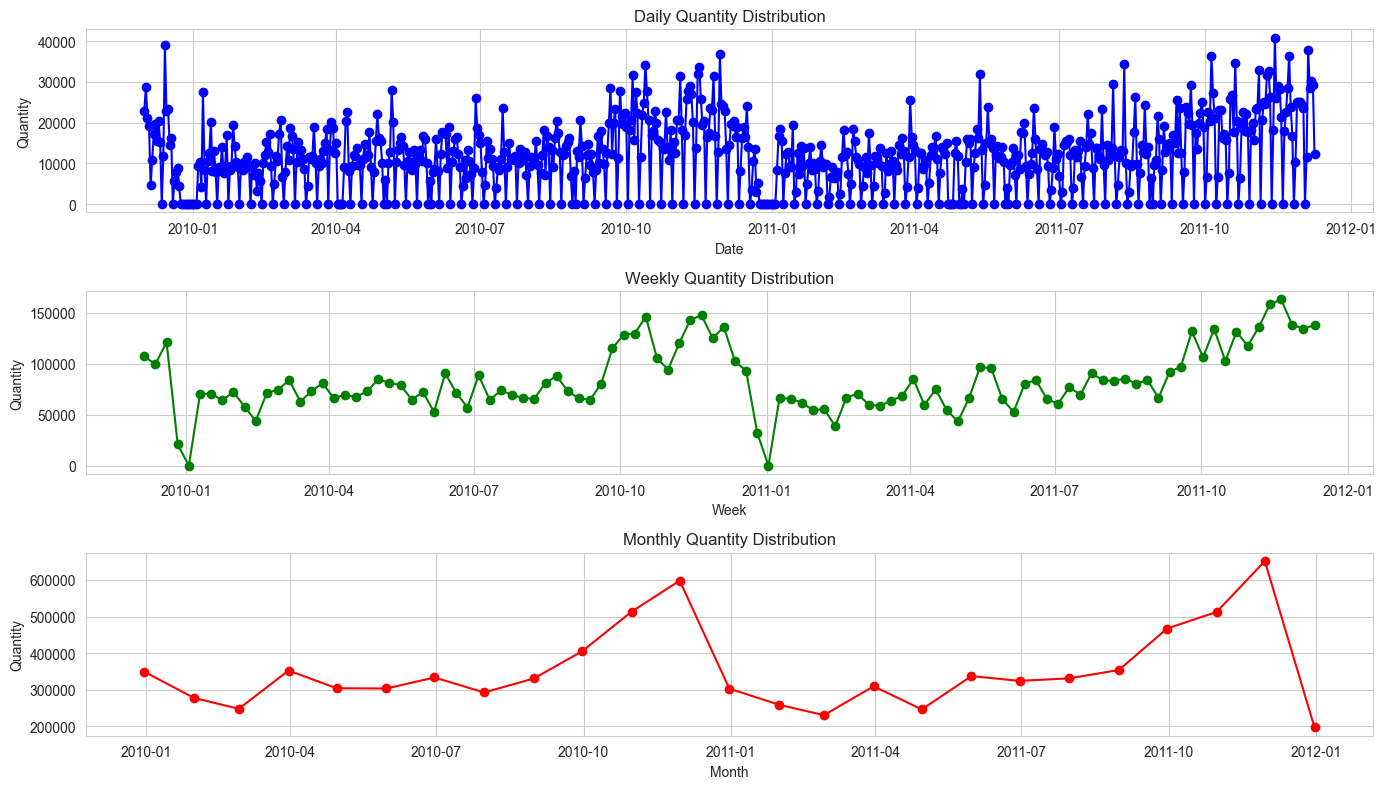

In [43]:

daily_sales = df_clean.resample('D', on='invoice_date')['qty'].sum()
weekly_sales = df_clean.resample('W', on='invoice_date')['qty'].sum()
monthly_sales = df_clean.resample('M', on='invoice_date')['qty'].sum()

# Plotting the distributions
plt.figure(figsize=(14, 8))

# Daily sales distribution
plt.subplot(3, 1, 1)
plt.plot(daily_sales.index, daily_sales.values, marker='o', linestyle='-', color='blue')
plt.title('Daily Quantity Distribution')
plt.xlabel('Date')
plt.ylabel('Quantity')

# Weekly sales distribution
plt.subplot(3, 1, 2)
plt.plot(weekly_sales.index, weekly_sales.values, marker='o', linestyle='-', color='green')
plt.title('Weekly Quantity Distribution')
plt.xlabel('Week')
plt.ylabel('Quantity')

# Monthly sales distribution
plt.subplot(3, 1, 3)
plt.plot(monthly_sales.index, monthly_sales.values, marker='o', linestyle='-', color='red')
plt.title('Monthly Quantity Distribution')
plt.xlabel('Month')
plt.ylabel('Quantity')

plt.tight_layout()

Let's plot the qty distribution as well

<Figure size 1400x800 with 0 Axes>

<Axes: >

<Axes: xlabel='qty', ylabel='Count'>

Text(0.5, 1.0, 'Daily Quantity Distribution')

Text(0.5, 0, 'Quantity')

Text(0, 0.5, 'Density')

<Axes: >

<Axes: xlabel='qty', ylabel='Count'>

Text(0.5, 1.0, 'Weekly Quantity Distribution')

Text(0.5, 0, 'Quantity')

Text(0, 0.5, 'Density')

<Axes: >

<Axes: xlabel='qty', ylabel='Count'>

Text(0.5, 1.0, 'Monthly Quantity Distribution')

Text(0.5, 0, 'Quantity')

Text(0, 0.5, 'Density')

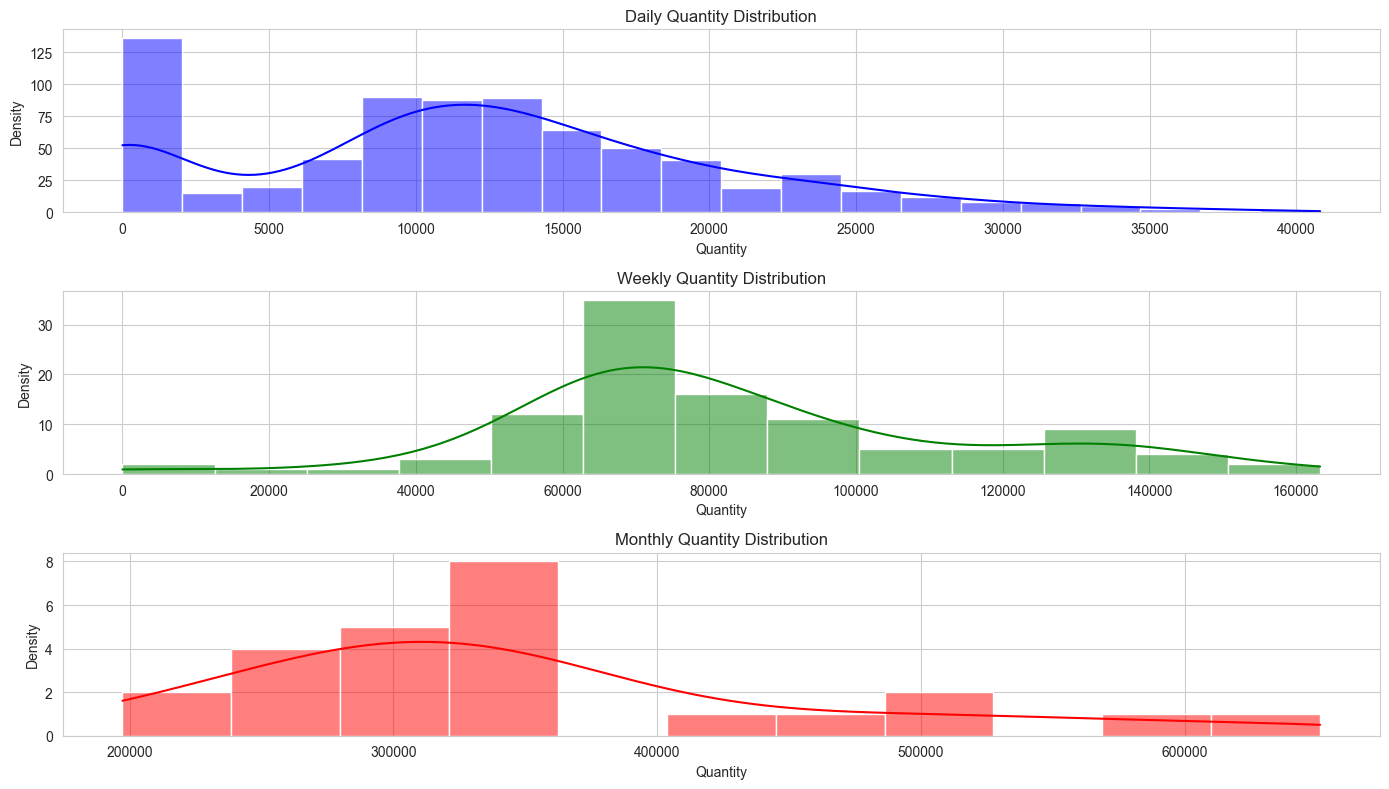

In [44]:
plt.figure(figsize=(14, 8))

# Daily distribution
plt.subplot(3, 1, 1)
sns.histplot(daily_sales, kde=True, color='blue')
plt.title('Daily Quantity Distribution')
plt.xlabel('Quantity')
plt.ylabel('Density')

# Weekly distribution
plt.subplot(3, 1, 2)
sns.histplot(weekly_sales, kde=True, color='green')
plt.title('Weekly Quantity Distribution')
plt.xlabel('Quantity')
plt.ylabel('Density')

# Monthly distribution
plt.subplot(3, 1, 3)
sns.histplot(monthly_sales, kde=True, color='red')
plt.title('Monthly Quantity Distribution')
plt.xlabel('Quantity')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

### Unit Price

Due to the analysis above, let's try to discern more about this filed. First of all, we noticed that for a given stock code, there are more prices. This depends on both country and time (for what we saw above). Moreover, it could depend also on qty (the more I order the less I pay) Let's create two fields with the most frequent price for each item and the median

unit_price
count  929718.000000
mean        3.401239
std         4.721204
min         0.040000
25%         1.250000
50%         2.100000
75%         4.150000
max      1157.150024

qty  unit_price
0.0000    1.0    0.040000
0.0500    1.0    0.420000
0.9500   30.0    9.950000
0.9800   64.0   13.570000
0.9900  100.0   16.950001
0.9990  288.0   34.950001
0.9999  432.0  125.000000

<Axes: xlabel='unit_price', ylabel='Count'>

Text(0.5, 1.0, 'unit_price distribution')

<Axes: xlabel='unit_price', ylabel='Count'>

Text(0.5, 1.0, 'Log-unit_price distribution')

Text(0.5, 0, 'Natural-Log unit_price')

<Axes: ylabel='unit_price'>

Text(0.5, 1.0, 'unit_price distribution')

<Axes: ylabel='unit_price'>

Text(0.5, 1.0, 'Log-unit_price distribution')

Text(0.5, 0, 'Natural-Log unit_price')

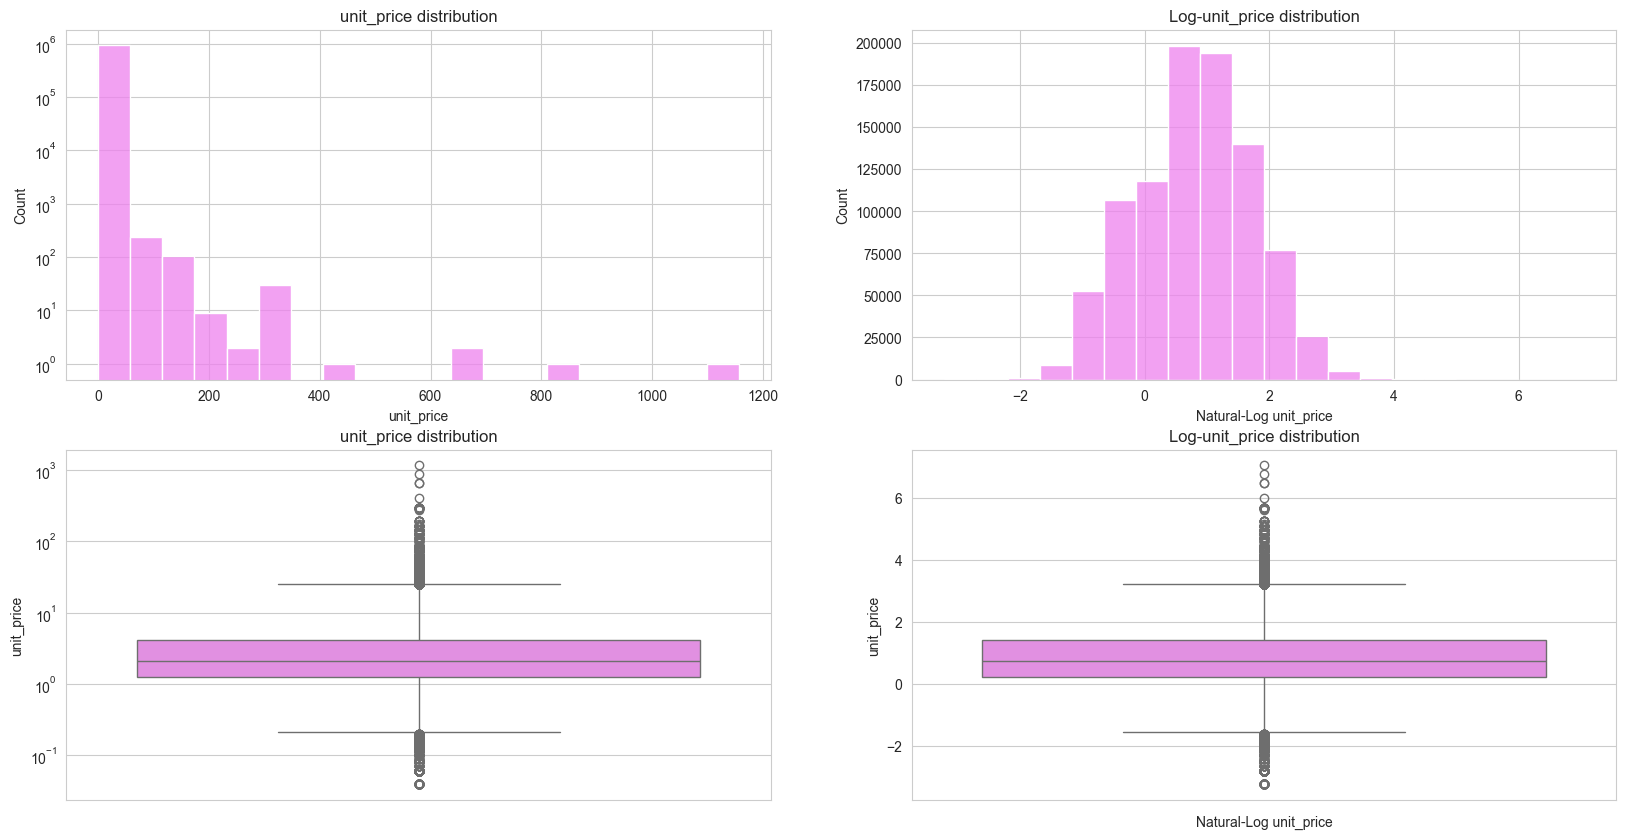

In [45]:
df_clean = df_clean[df_clean['unit_price'] > 0]

df_clean[['unit_price']].describe()


df_clean[['qty','unit_price']].quantile([0,0.05, 0.95, 0.98, 0.99, 0.999, 0.9999])

fig, ax = plt.subplots(2, 2, figsize=(20, 10))

# Plotting unit_price distribution
sns.histplot(df_clean.unit_price, ax=ax[0][0], bins=20, color="violet", log_scale=(False, True))
ax[0][0].set_title("unit_price distribution")
ax[0][0].set_yscale("log")  # Ensure the y-axis is log-scaled

# Plotting log-transformed unit_price distribution
sns.histplot(np.log(df_clean.unit_price), ax=ax[0][1], bins=20, color="violet")
ax[0][1].set_title("Log-unit_price distribution")
ax[0][1].set_xlabel("Natural-Log unit_price")



# Plotting unit_price distribution
sns.boxplot(df_clean.unit_price, ax=ax[1][0], color="violet", log_scale=(False, True))
ax[1][0].set_title("unit_price distribution")
ax[1][0].set_yscale("log")  # Ensure the y-axis is log-scaled

# Plotting log-transformed unit_price distribution
sns.boxplot(np.log(df_clean.unit_price), ax=ax[1][1], color="violet")
ax[1][1].set_title("Log-unit_price distribution")
ax[1][1].set_xlabel("Natural-Log unit_price")

Let's visit the stock with more than one unit_prices

Text(0.5, 0, 'Number of different prices')

Text(0, 0.5, 'Count stock_code')

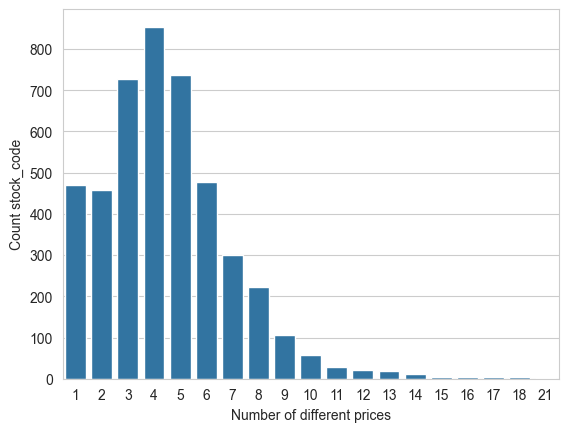

In [46]:
df_temp = df_clean.groupby(by = 'stock_code')['unit_price'].nunique().value_counts()

ax = sns.barplot(df_temp)
ax.set_xlabel("Number of different prices")
ax.set_ylabel("Count stock_code")

Let'manually exclude real strange unit prices like those for stock 84016

Most of the unit prices seems ok since the same stock shoes several times similar (high) prices

In [47]:
#df_clean[df_clean.unit_price >= df_clean.unit_price.quantile(0.999)]

lst_code_high_value = df_clean[df_clean.unit_price >= df_clean.unit_price.quantile(0.9999)]['stock_code'].unique().tolist()
print(lst_code_high_value)
stock = random.choice(lst_code_high_value)

df_clean[df_clean.stock_code == '22502'].sort_values('unit_price', ascending = False)

['21760', '84016', '85070', '22656', '22655', '84965B', '22827', '22828', '22823', '22826', '22502']


invoice_id stock_code                 description  qty  \
748143     556446      22502  picnic basket wicker small    1   
748132     556444      22502  picnic basket wicker small   60   
661913     547964      22502  picnic basket wicker small    1   
744578     556083      22502  picnic basket wicker small    1   
744518     556081      22502  picnic basket wicker small    3   
...           ...        ...                         ...  ...   
258653     514355      22502  picnic basket wicker small   17   
251715     513649      22502  picnic basket wicker small   48   
235710     512247      22502  picnic basket wicker small   16   
233109     511968      22502  picnic basket wicker small   16   
884937     568188      22502  picnic basket wicker small    1   

         invoice_timestamp  unit_price customer_id         country  \
748143 2011-06-10 15:33:00      649.50       15098  United Kingdom   
748132 2011-06-10 15:28:00      649.50       15098  United Kingdom   
661913 2011-03-28 15:45:00       10.79         NaN  United Kingdom   
744578 2011-06-08 15:23:00       10.79         NaN  United Kingdom   
744518 2011-06-08 15:22:00       10.79         NaN  United Kingdom   
...                    ...         ...         ...             ...   
258653 2010-07-01 16:48:00        3.75       17589  United Kingdom   
251715 2010-06-28 08:34:00        3.75       14646     Netherlands   
235710 2010-06-14 12:41:00        3.75       13093  United Kingdom   
233109 2010-06-11 13:44:00        3.75       13093  United Kingdom   
884937 2011-09-25 14:33:00        2.00       16049  United Kingdom   

       invoice_date  invoice_day invoice_day_name  invoice_week  \
748143   2011-06-10           10           Friday            23   
748132   2011-06-10           10           Friday            23   
661913   2011-03-28           28           Monday            13   
744578   2011-06-08            8        Wednesday            23   
744518   2011-06-08            8        Wednesday            23   
...             ...          ...              ...           ...   
258653   2010-07-01            1         Thursday            26   
251715   2010-06-28           28           Monday            26   
235710   2010-06-14           14           Monday            24   
233109   2010-06-11           11           Friday            23   
884937   2011-09-25           25           Sunday            38   

        invoice_month  invoice_quarter  invoice_year  is_cancelled  
748143              6                2          2011         False  
748132              6                2          2011         False  
661913              3                1          2011         False  
744578              6                2          2011         False  
744518              6                2          2011         False  
...               ...              ...           ...           ...  
258653              7                3          2010         False  
251715              6                2          2010         False  
235710              6                2          2010         False  
233109              6                2          2010         False  
884937              9                3          2011         False  

[924 rows x 16 columns]

In [48]:
df_clean = df_clean[~df_clean.index.isin(['192196', '136403', '180997', '114155', '248762', '117876', '136494','179302', '200664', '181647', '123902', '346540', '748143', '748132'])]

Let's create the columns as per what said above. Moreover, let's create another unit price column with the last (chronological speaking) available price for each stock

In [49]:
df_clean['unit_price_mode'] = df_clean.groupby(by = 'stock_code')['unit_price'].transform(lambda x: pd.Series.mode(x)[0])
df_clean['unit_price_median'] = df_clean.groupby(by = 'stock_code')['unit_price'].transform(lambda x: pd.Series.median(x))

df_temp = df_clean

In [50]:
df_temp = df_clean.sort_values(by = 'invoice_date').groupby(by = ['stock_code'], as_index = False).agg(unit_price_last = ('unit_price', 'last'))

df_clean = df_clean.merge(df_temp, on = 'stock_code', how = 'left')

### Customer ID

Despite there are a lot of NaN customers, we can keep them. Due to the operations above, now we should have a database with most of the transactions to be valid. Moreover, due to the goal of this project, the column customer ID will be useless (probably useless). So no operations needed

In [51]:
df_clean[['customer_id']].describe()

customer_id
count       718042
unique        5811
top          17841
freq         11353

### Country

As for Customer, this columns could be pretty useless, moreover, most of the transaction come from UK.

In [52]:
df_clean[['country']].describe()

country
count           929704
unique              43
top     United Kingdom
freq            858004

In [53]:
df_clean['country'].unique()

array(['United Kingdom', 'France', 'EIRE', 'Germany', 'Portugal',
       'Netherlands', 'Poland', 'Channel Islands', 'Spain', 'Cyprus',
       'Belgium', 'Greece', 'Norway', 'Austria', 'Sweden',
       'United Arab Emirates', 'Finland', 'Denmark', 'Italy',
       'Switzerland', 'Australia', 'USA', 'Unspecified', 'Japan', 'Malta',
       'Bahrain', 'RSA', 'Bermuda', 'Hong Kong', 'Singapore', 'Thailand',
       'Israel', 'Lithuania', 'Nigeria', 'West Indies', 'Lebanon',
       'Brazil', 'Canada', 'Iceland', 'Korea', 'Saudi Arabia',
       'Czech Republic', 'European Community'], dtype=object)

In [54]:
from plotly.offline import init_notebook_mode,iplot

temp = df_clean[['customer_id', 'invoice_id', 'country']].groupby(['customer_id', 'invoice_id', 'country']).count()
temp = temp.reset_index(drop = False)
countries = temp['country'].value_counts()

data = dict(type='choropleth',
locations = countries.index,
locationmode = 'country names', z = countries,
text = countries.index, colorbar = {'title':'Order nb.'},
colorscale=[[0, 'rgb(224,255,255)'],
            [0.01, 'rgb(166,206,227)'], [0.02, 'rgb(31,120,180)'],
            [0.03, 'rgb(178,223,138)'], [0.05, 'rgb(51,160,44)'],
            [0.10, 'rgb(251,154,153)'], [0.20, 'rgb(255,255,0)'],
            [1, 'rgb(227,26,28)']],    
reversescale = False)


layout = dict(title='Number of orders per country',
                geo = dict(showframe = True, projection={'type':'mercator'}),
                width=1200, 
                height=800  )


choromap = go.Figure(data = [data], layout = layout)
iplot(choromap, validate=False)

### Wrap up

In [55]:
df_clean = data_cleaning()

Start Cleaning Process...
CLEANING INVOICE
CLEANING STOCK CODE
CLEANING DESCRIPTION
CLEANING QUANTITY
CLEANING PRICE
We dropped 141592 records

End!


## EDA

Let's answer the following questions.
1) What are most valuable items?
2) Are there peaks in specific months?
3) Who is the most profitable customer?


### 1) What are most valuable items?

- one person meta sign is the item with the highest unit price value (code 21181)
- Regency cake stand 3 tier is the item with the highest revenue (code 22423)
- jumbo bag is the most ordered item (code 85099B)


(<Figure size 1000x600 with 1 Axes>, <Axes: >)

<Axes: xlabel='stock_code,description'>

Text(0.5, 0, 'Product ID')

Text(0, 0.5, 'Price')

Text(0.5, 1.0, 'Most valuable products by unit price')

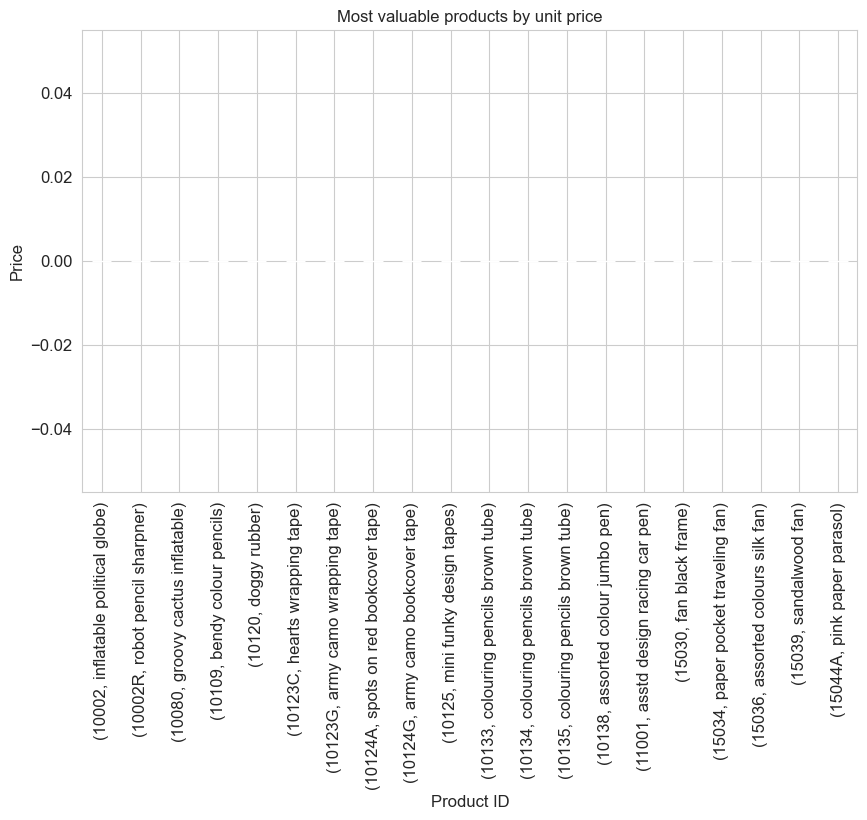

In [56]:

df_clean['unit_price_mode'] = df_clean.groupby(by='stock_code')['price'].agg(lambda x: pd.Series.mode(x)[0])

most_profitable_product = df_clean.groupby(by=['stock_code','description'])['unit_price_mode'].max().sort_values(ascending=False).iloc[:20]
plt.subplots(figsize=(10,6))
most_profitable_product.plot(kind='bar', fontsize=12, color=color[0])
plt.xlabel('Product ID', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.title('Most valuable products by unit price', fontsize=12)

(<Figure size 1000x600 with 1 Axes>, <Axes: >)

<Axes: xlabel='stock_code,description'>

Text(0.5, 0, 'Product ID')

Text(0, 0.5, 'Total earning')

Text(0.5, 1.0, 'Most valuable products by revenue')

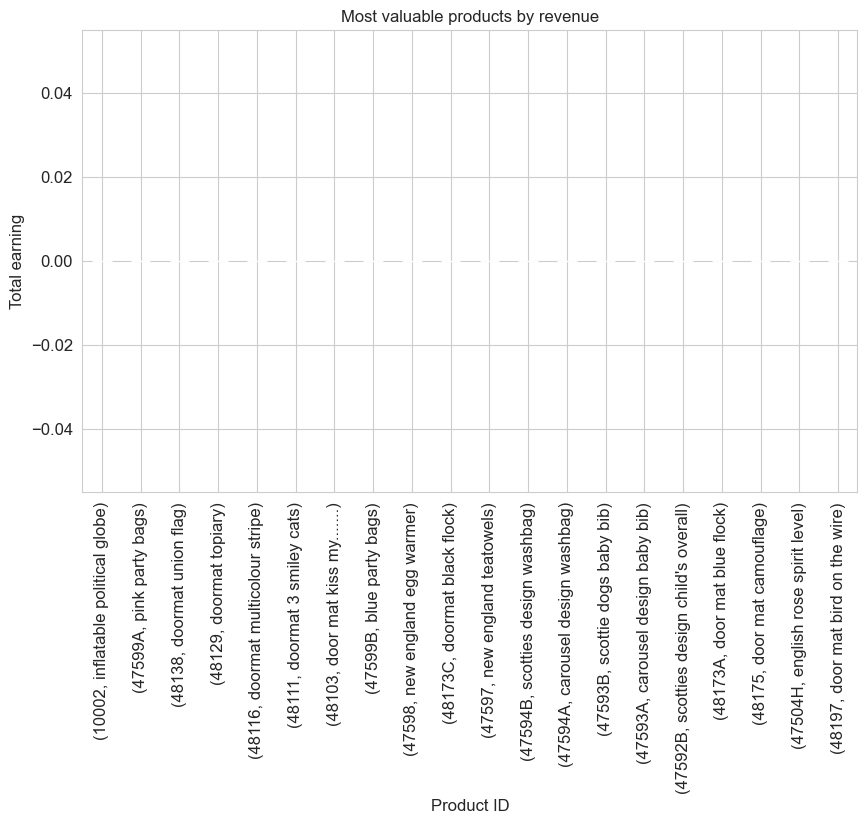

In [57]:

df_temp = df_clean.assign(revenue = df_clean['unit_price_mode']*df_clean['qty'])

most_profitable_product = df_temp.groupby(by=['stock_code','description'])['revenue'].sum().sort_values(ascending=False).iloc[:20]
plt.subplots(figsize=(10,6))
most_profitable_product.plot(kind='bar', fontsize=12, color=color[0])
plt.xlabel('Product ID', fontsize=12)
plt.ylabel('Total earning', fontsize=12)
plt.title('Most valuable products by revenue', fontsize=12)

(<Figure size 1000x600 with 1 Axes>, <Axes: >)

<Axes: xlabel='stock_code,description'>

Text(0.5, 0, 'Product ID')

Text(0, 0.5, 'Amount sold')

Text(0.5, 1.0, 'Most sold products')

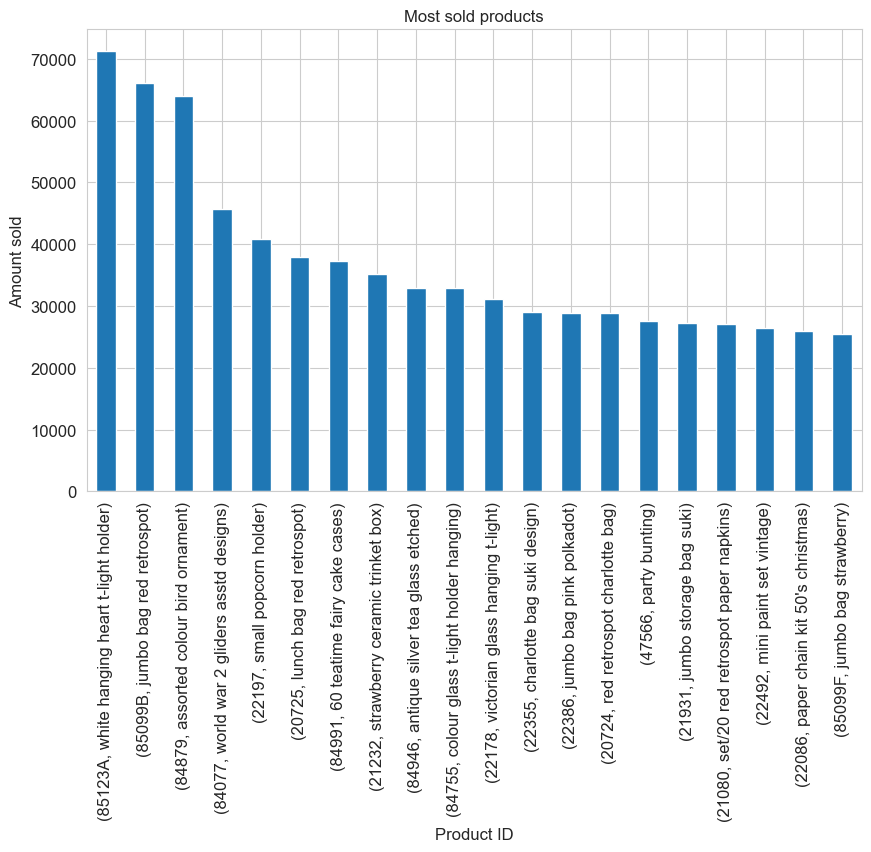

In [58]:
most_sold_products=df_clean.groupby(by=['stock_code','description'])['qty'].sum().sort_values(ascending=False).iloc[:20]

plt.subplots(figsize=(10,6))
most_sold_products.plot(kind='bar', fontsize=12, color=color[0])
plt.xlabel('Product ID', fontsize=12)
plt.ylabel('Amount sold', fontsize=12)
plt.title('Most sold products', fontsize=12)

### 2) Are there peaks in specific months?

Per what we saw before, we have the peaks in November, with Christmas hipe starting from September till November. There is also a little peak in March

### 3) Who is the most profitable customer?

- 114135 is the customer who spents more
- 14646 is the customer who orders more


(<Figure size 1000x600 with 1 Axes>, <Axes: >)

<Axes: xlabel='customer_id'>

Text(0.5, 0, 'Customer ID')

Text(0, 0.5, 'Revenue')

Text(0.5, 1.0, 'Most valuable customer by revenue')

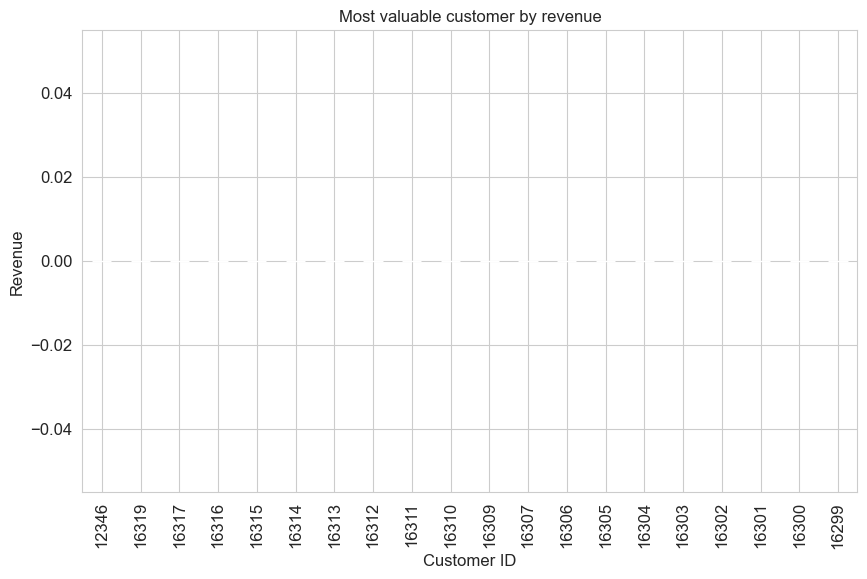

In [59]:
df_temp = df_clean.assign(revenue = df_clean['unit_price_mode']*df_clean['qty'])

most_profitable_customer = df_temp.groupby(by=['customer_id'])['revenue'].sum().sort_values(ascending=False).iloc[:20]
plt.subplots(figsize=(10,6))
most_profitable_customer.plot(kind='bar', fontsize=12, color=color[0])
plt.xlabel('Customer ID', fontsize=12)
plt.ylabel('Revenue', fontsize=12)
plt.title('Most valuable customer by revenue', fontsize=12)

(<Figure size 1000x600 with 1 Axes>, <Axes: >)

<Axes: xlabel='customer_id'>

Text(0.5, 0, 'Customer ID')

Text(0, 0.5, 'Revenue')

Text(0.5, 1.0, 'Most valuable customer by revenue')

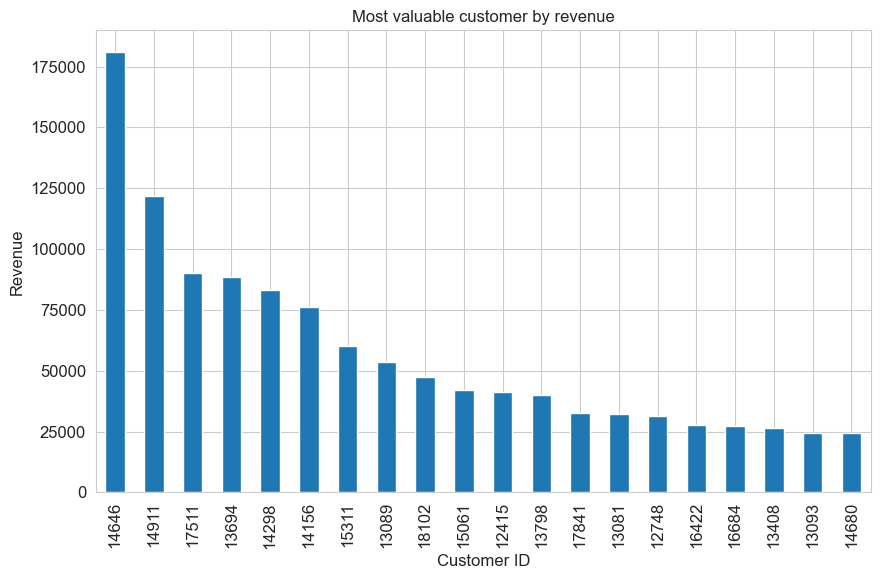

In [60]:

most_profitable_customer = df_temp.groupby(by=['customer_id'])['qty'].sum().sort_values(ascending=False).iloc[:20]
plt.subplots(figsize=(10,6))
most_profitable_customer.plot(kind='bar', fontsize=12, color=color[0])
plt.xlabel('Customer ID', fontsize=12)
plt.ylabel('Revenue', fontsize=12)
plt.title('Most valuable customer by revenue', fontsize=12)

## Modelling

Let's use [CatBoost regressor](https://towardsdatascience.com/catboost-regression-in-6-minutes-3487f3e5b329) to perform a regression with target columns = qty and many many features. Since we want to simulate a forecasting model, lets perform some feature engineering

### Wrap Up

Start Cleaning Process...
CLEANING INVOICE
CLEANING STOCK CODE
CLEANING DESCRIPTION
CLEANING QUANTITY
CLEANING PRICE
We dropped 141592 records

End!

Preparing data for the model...
 FEATURE ENGINEERING
For n_clusters = 2, the average silhouette score is 0.4039
For n_clusters = 3, the average silhouette score is 0.3006
For n_clusters = 4, the average silhouette score is 0.2879
For n_clusters = 5, the average silhouette score is 0.2776
For n_clusters = 6, the average silhouette score is 0.2892
For n_clusters = 7, the average silhouette score is 0.2659
For n_clusters = 8, the average silhouette score is 0.2533
For n_clusters = 9, the average silhouette score is 0.2451
For n_clusters = 10, the average silhouette score is 0.2461


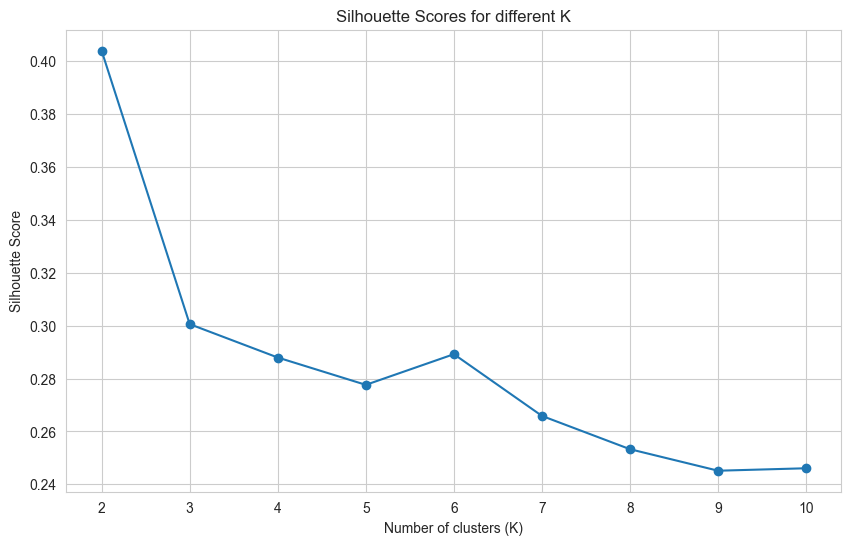


Optimal number of clusters: 2


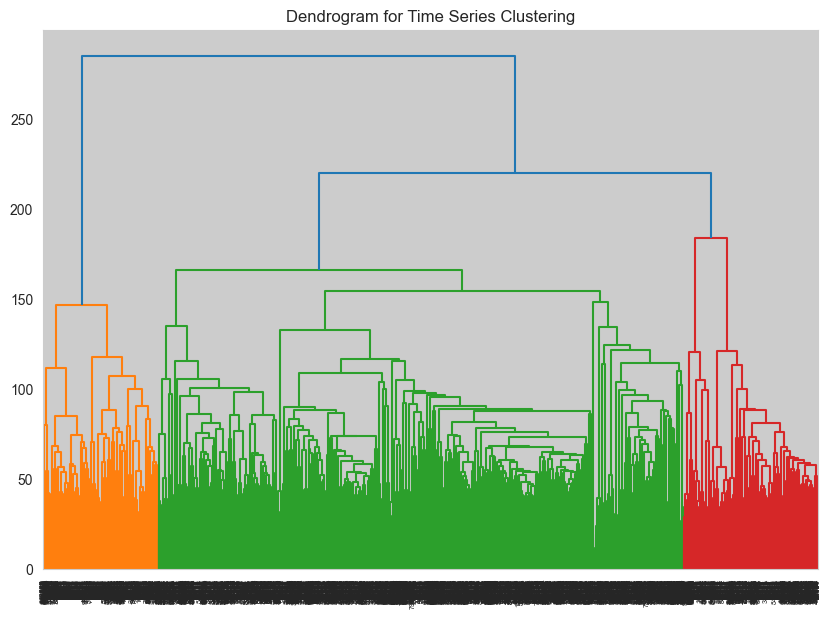

count    556718.000000
mean         13.124147
std          22.721765
min           1.000000
25%           2.000000
50%           5.000000
75%          13.000000
max         600.000000
Name: qty, dtype: float64

In [61]:
df_model = data_model_preparation()

df_model['qty'].describe()

### Fine Tuning

In [62]:
days = df_model.date.max() - pd.Timedelta(days=42)
df_model_train = df_model[df_model.date < days]
df_model_test= df_model[df_model.date >= days]

try:
    X_train = df_model_train.drop(columns=['qty', 'predictions', 'year'])
except:
    X_train = df_model_train.drop(columns=['qty', 'year'])
y_train = df_model_train['qty']

try:
    X_test = df_model_test.drop(columns=['qty', 'predictions', 'year'])
except:
    X_test = df_model_test.drop(columns=['qty', 'year'])
y_test = df_model_test['qty']

In [63]:


"""

# Define the parameter distribution for random search
param_dist = {
    'iterations': np.random.randint(500, 2000, 10),  # Randomly sample between 500 and 2000 iterations
    'learning_rate': np.linspace(0.01, 0.2, 10),  # Learning rate between 0.01 and 0.2
    'depth': np.random.randint(4, 10, 5),  # Randomly sample tree depth between 4 and 10
    'l2_leaf_reg': np.random.uniform(1, 10, 5),  # L2 regularization coefficient
    'bagging_temperature': np.random.uniform(0, 1, 5),  # Bagging temperature
    'random_strength': np.random.uniform(1, 5, 5),  # Random strength for robustness
    'loss_function': ['RMSE']  # Loss function
}

# Initialize the CatBoostRegressor
model = CatBoostRegressor(
    eval_metric='RMSE',
    random_seed=42,
    silent=True
)

# Generate or load a list of sample weights corresponding to the rows in X
# Example: assuming the sample weights are in a column 'weights' in df_model
sample_weights = X_train['price_mode'].values  # or create your custom list of weights

# Create a Pool object with features (X), target (y), and sample weights
cat_features =X_train.select_dtypes(include=['object']).columns.tolist()
for col in cat_features:
    X_train[col] =X_train[col].astype(str)
cat_features = X_train.select_dtypes(include=['object']).columns.tolist()

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=model, 
                                   param_distributions=param_dist, 
                                   n_iter=50, 
                                   scoring='neg_root_mean_squared_error', 
                                   cv=3, 
                                   verbose=1, 
                                   n_jobs=-1, 
                                   random_state=42)


random_search.fit(X_train, y_train, sample_weight=sample_weights, cat_features=cat_features)

# Best parameters and best score from the randomized search
best_params = random_search.best_params_
best_score = -random_search.best_score_  # Negative RMSE due to the scoring method

# Output the results
print(f"Best Parameters: {best_params}")
print(f"Best RMSE Score: {best_score}")

# If you want to use the best estimator, you can access it like this:
best_model = random_search.best_estimator_
best_model.save_model('best_catboost_model.cbm')
"""

'\n\n# Define the parameter distribution for random search\nparam_dist = {\n    \'iterations\': np.random.randint(500, 2000, 10),  # Randomly sample between 500 and 2000 iterations\n    \'learning_rate\': np.linspace(0.01, 0.2, 10),  # Learning rate between 0.01 and 0.2\n    \'depth\': np.random.randint(4, 10, 5),  # Randomly sample tree depth between 4 and 10\n    \'l2_leaf_reg\': np.random.uniform(1, 10, 5),  # L2 regularization coefficient\n    \'bagging_temperature\': np.random.uniform(0, 1, 5),  # Bagging temperature\n    \'random_strength\': np.random.uniform(1, 5, 5),  # Random strength for robustness\n    \'loss_function\': [\'RMSE\']  # Loss function\n}\n\n# Initialize the CatBoostRegressor\nmodel = CatBoostRegressor(\n    eval_metric=\'RMSE\',\n    random_seed=42,\n    silent=True\n)\n\n# Generate or load a list of sample weights corresponding to the rows in X\n# Example: assuming the sample weights are in a column \'weights\' in df_model\nsample_weights = X_train[\'price_mod

### Baseline model result

In [64]:
try:
    X = df_model.drop(columns=['qty', 'predictions', 'year'])
except:
    X = df_model.drop(columns=['qty', 'year'])
y = df_model['qty']


params = {
    'loss': 'RMSE',
    'seed': 42,
    'iterations': 1000,
    'max_depth': 6,
    'eval_metric': 'RMSE',
    'learning_rate': 0.01
    
       
}
model = Catmodel('base', params)


days = df_model.date.max() - pd.Timedelta(days=42)
model.set_data(X,y, days)
model.learn(plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

base, early-stopped model tree count: 998


In [65]:
model.score()

0.42220350129774

In [66]:
#model.show_val_results();

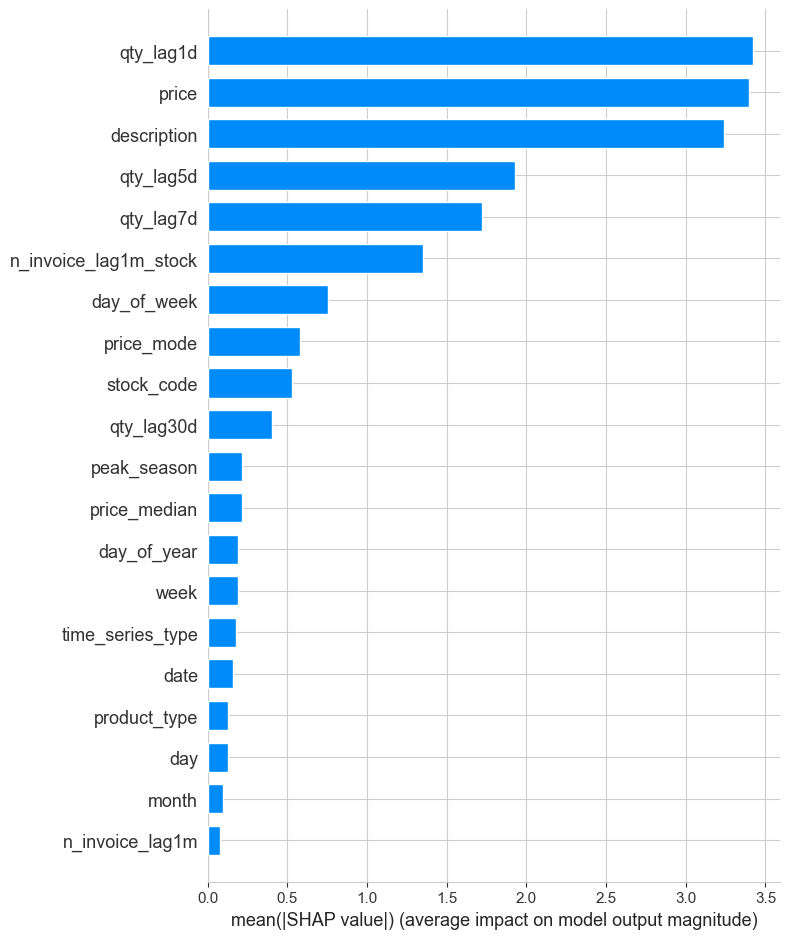

In [67]:
model.show_importances()

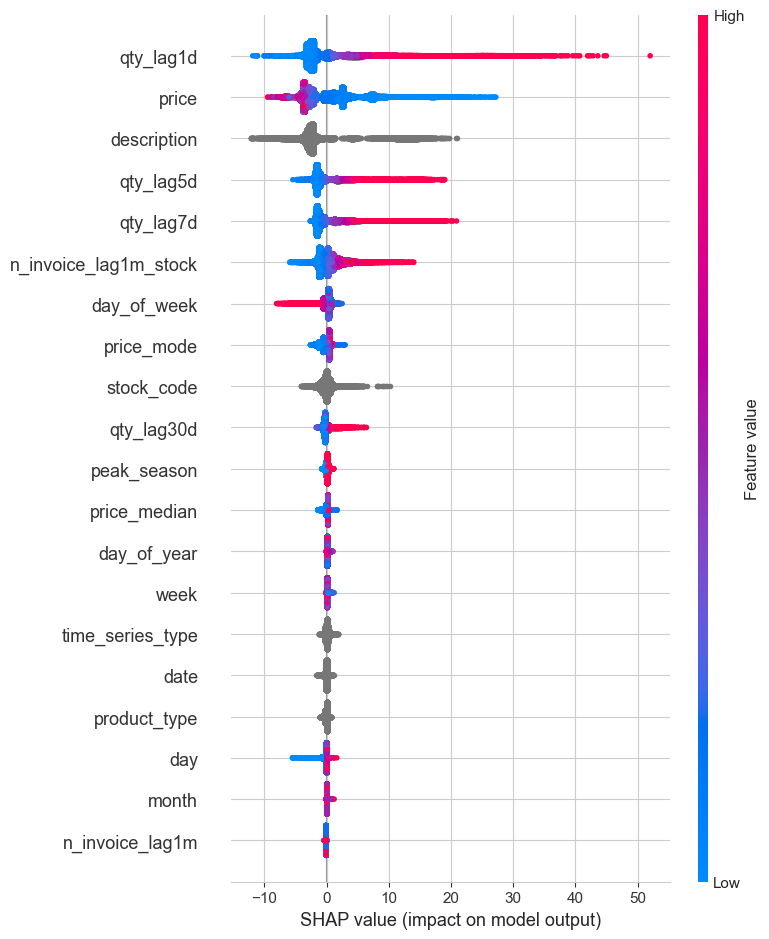

In [68]:
model.show_importances(kind=None)

In [69]:
df_model['predictions'] = model.predict(X)

As we can see in the validation set, the model is more likely to over-forecast the qty. This is because these are the most valuable items

In [70]:
most_val_items = np.argmax([df_model[df_model.product_type == i]['price'].mean() for i in range(len(df_model.product_type.unique()))])

126183.24356073582

123486

<Figure size 2000x800 with 0 Axes>

<Axes: xlabel='date'>

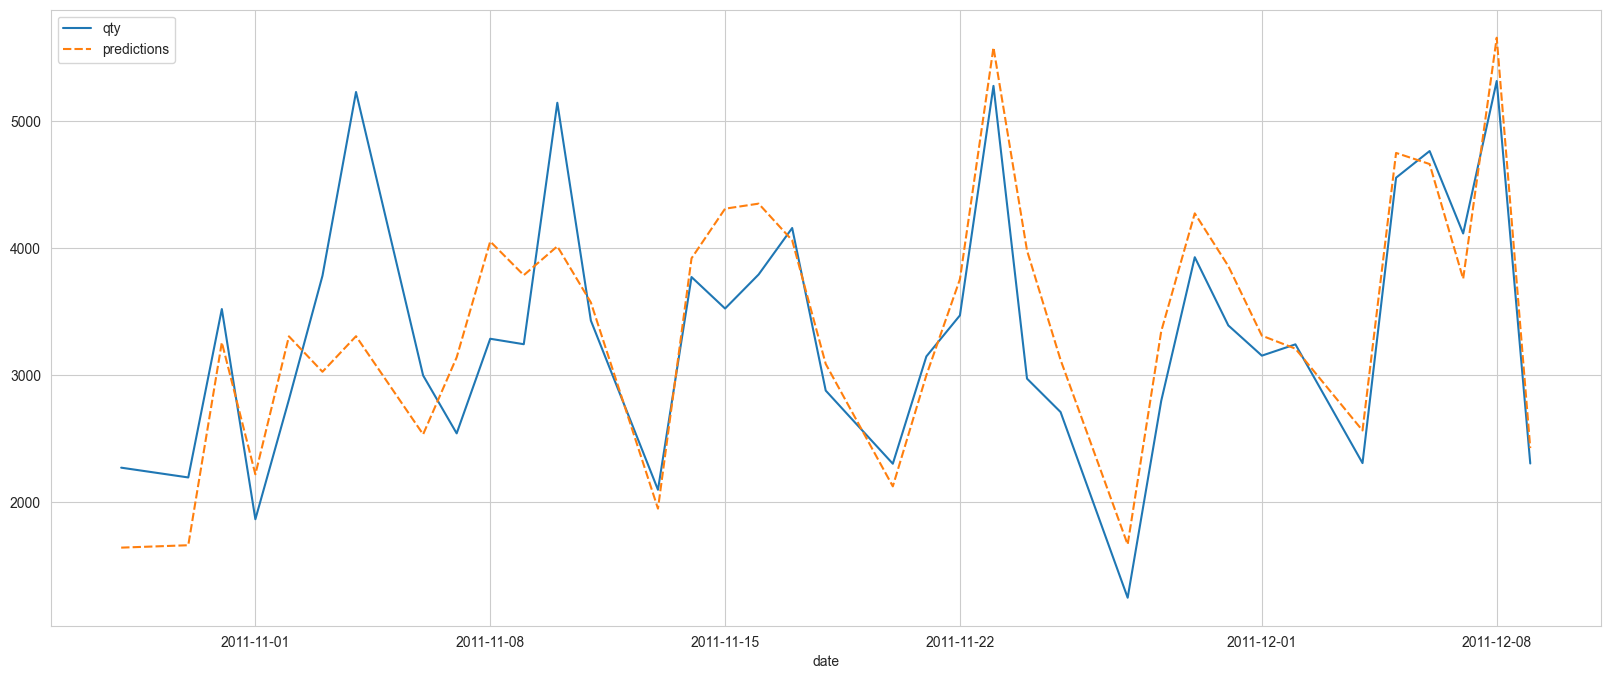

In [71]:
df_temp = df_model[(df_model['product_type'] == most_val_items) & (df_model.date >= df_model.date.max() -pd.Timedelta(days=42))].groupby(by = 'date')[['qty','predictions']].sum()

df_temp['predictions'].sum()
df_temp['qty'].sum()
plt.figure(figsize=(20,8))
sns.lineplot(df_temp)

<Figure size 2000x800 with 0 Axes>

<Axes: xlabel='date'>

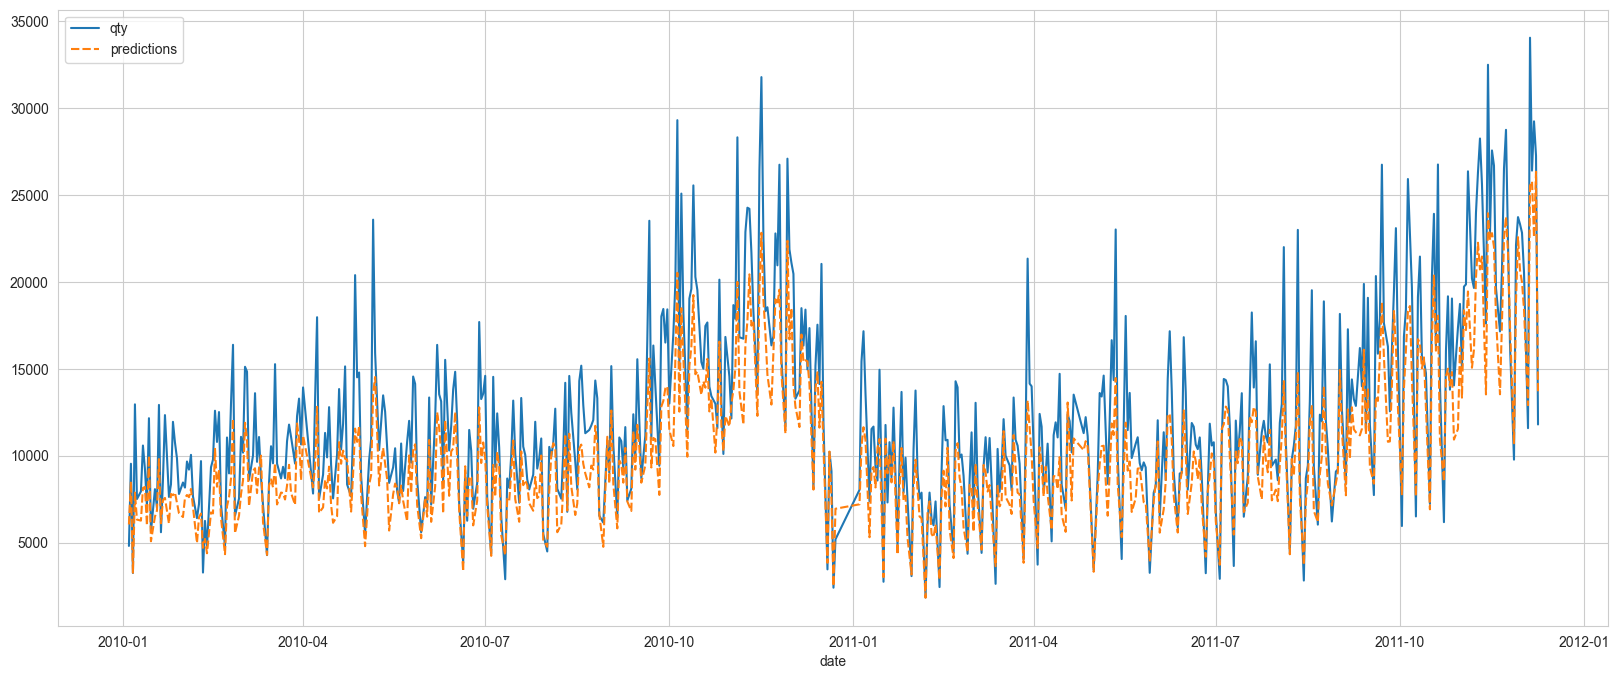

In [72]:
df_temp = df_model.groupby(by = 'date')[['qty','predictions']].sum()


plt.figure(figsize=(20,8))
sns.lineplot(df_temp)

### Fine Tuning

In [73]:
days = df_model.date.max() - pd.Timedelta(days=42)
df_model_train = df_model[df_model.date < days]
df_model_test= df_model[df_model.date >= days]

try:
    X_train = df_model_train.drop(columns=['qty', 'predictions', 'year'])
except:
    X_train = df_model_train.drop(columns=['qty', 'year'])
y_train = df_model_train['qty']

try:
    X_test = df_model_test.drop(columns=['qty', 'predictions', 'year'])
except:
    X_test = df_model_test.drop(columns=['qty', 'year'])
y_test = df_model_test['qty']


cat_features =X_train.select_dtypes(include=['object']).columns.tolist()
for col in cat_features:
    X_train[col] =X_train[col].astype(str)
cat_features = X_train.select_dtypes(include=['object']).columns.tolist()

cat_features =X_test.select_dtypes(include=['object']).columns.tolist()
for col in cat_features:
    X_test[col] =X_test[col].astype(str)
cat_features = X_test.select_dtypes(include=['object']).columns.tolist()

In [74]:

"""

# Define the parameter distribution for random search
param_dist = {
    'iterations': np.random.randint(500, 2000, 10),  # Randomly sample between 500 and 2000 iterations
    'learning_rate': np.linspace(0.01, 0.2, 10),  # Learning rate between 0.01 and 0.2
    'depth': np.random.randint(4, 10, 5),  # Randomly sample tree depth between 4 and 10
    'l2_leaf_reg': np.random.uniform(1, 10, 5),  # L2 regularization coefficient
    'bagging_temperature': np.random.uniform(0, 1, 5),  # Bagging temperature
    'random_strength': np.random.uniform(1, 5, 5),  # Random strength for robustness
    'loss_function': ['RMSE']  # Loss function
}

# Initialize the CatBoostRegressor
model = CatBoostRegressor(
    eval_metric='RMSE',
    random_seed=42,
    silent=True
)

# Generate or load a list of sample weights corresponding to the rows in X
# Example: assuming the sample weights are in a column 'weights' in df_model
sample_weights = X_train['price_mode'].values  # or create your custom list of weights

# Create a Pool object with features (X), target (y), and sample weights
cat_features =X_train.select_dtypes(include=['object']).columns.tolist()
for col in cat_features:
    X_train[col] =X_train[col].astype(str)
cat_features = X_train.select_dtypes(include=['object']).columns.tolist()

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=model, 
                                   param_distributions=param_dist, 
                                   n_iter=50, 
                                   scoring='neg_root_mean_squared_error', 
                                   cv=3, 
                                   verbose=1, 
                                   n_jobs=-1, 
                                   random_state=42)


random_search.fit(X_train, y_train, sample_weight=sample_weights, cat_features=cat_features)

# Best parameters and best score from the randomized search
best_params = random_search.best_params_
best_score = -random_search.best_score_  # Negative RMSE due to the scoring method

# Output the results
print(f"Best Parameters: {best_params}")
print(f"Best RMSE Score: {best_score}")

# If you want to use the best estimator, you can access it like this:
best_model = random_search.best_estimator_
best_model.save_model('best_catboost_model.cbm')
"""

'\n\n# Define the parameter distribution for random search\nparam_dist = {\n    \'iterations\': np.random.randint(500, 2000, 10),  # Randomly sample between 500 and 2000 iterations\n    \'learning_rate\': np.linspace(0.01, 0.2, 10),  # Learning rate between 0.01 and 0.2\n    \'depth\': np.random.randint(4, 10, 5),  # Randomly sample tree depth between 4 and 10\n    \'l2_leaf_reg\': np.random.uniform(1, 10, 5),  # L2 regularization coefficient\n    \'bagging_temperature\': np.random.uniform(0, 1, 5),  # Bagging temperature\n    \'random_strength\': np.random.uniform(1, 5, 5),  # Random strength for robustness\n    \'loss_function\': [\'RMSE\']  # Loss function\n}\n\n# Initialize the CatBoostRegressor\nmodel = CatBoostRegressor(\n    eval_metric=\'RMSE\',\n    random_seed=42,\n    silent=True\n)\n\n# Generate or load a list of sample weights corresponding to the rows in X\n# Example: assuming the sample weights are in a column \'weights\' in df_model\nsample_weights = X_train[\'price_mod

### Best model result

In [75]:
loaded_model = CatBoostRegressor()
loaded_model.load_model('best_catboost_model.cbm')

predictions = loaded_model.predict(X_test)

test_pool = Pool(X_test, label=y_test, cat_features=cat_features)
metrics = loaded_model.eval_metrics(test_pool, metrics=['RMSE','R2'], plot=True)

r2 = metrics['R2'][-1]
rmse = metrics['RMSE'][-1]
print(f'R-squared (R2) on test: {r2:.4f}')
print(f'Root Mean Squared Errors (RMSE) on test: {rmse:.4f}')


train_pool = Pool(X_train, label=y_train, cat_features=cat_features)
metrics = loaded_model.eval_metrics(train_pool, metrics=['RMSE','R2'], plot=True)
r2_train = metrics['R2'][-1]
rmse_train = metrics['RMSE'][-1]
print(f'R-squared (R2) on train: {r2_train:.4f}')
print(f'Root Mean Squared Errors (RMSE) on train: {rmse_train:.4f}')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

R-squared (R2) on test: 0.4942
Root Mean Squared Errors (RMSE) on test: 18.0660


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

R-squared (R2) on train: 0.5779
Root Mean Squared Errors (RMSE) on train: 14.5405


In [76]:
df_model_train['predictions'] = loaded_model.predict(X_train)
df_model_test['predictions'] = loaded_model.predict(X_test)

In [77]:
most_val_items = np.argmax([df_model_train[df_model_train.product_type == i]['price'].mean() for i in range(len(df_model_train.product_type.unique()))])

1028069.2021056623

1091107

<Figure size 2000x800 with 0 Axes>

<Axes: xlabel='date'>

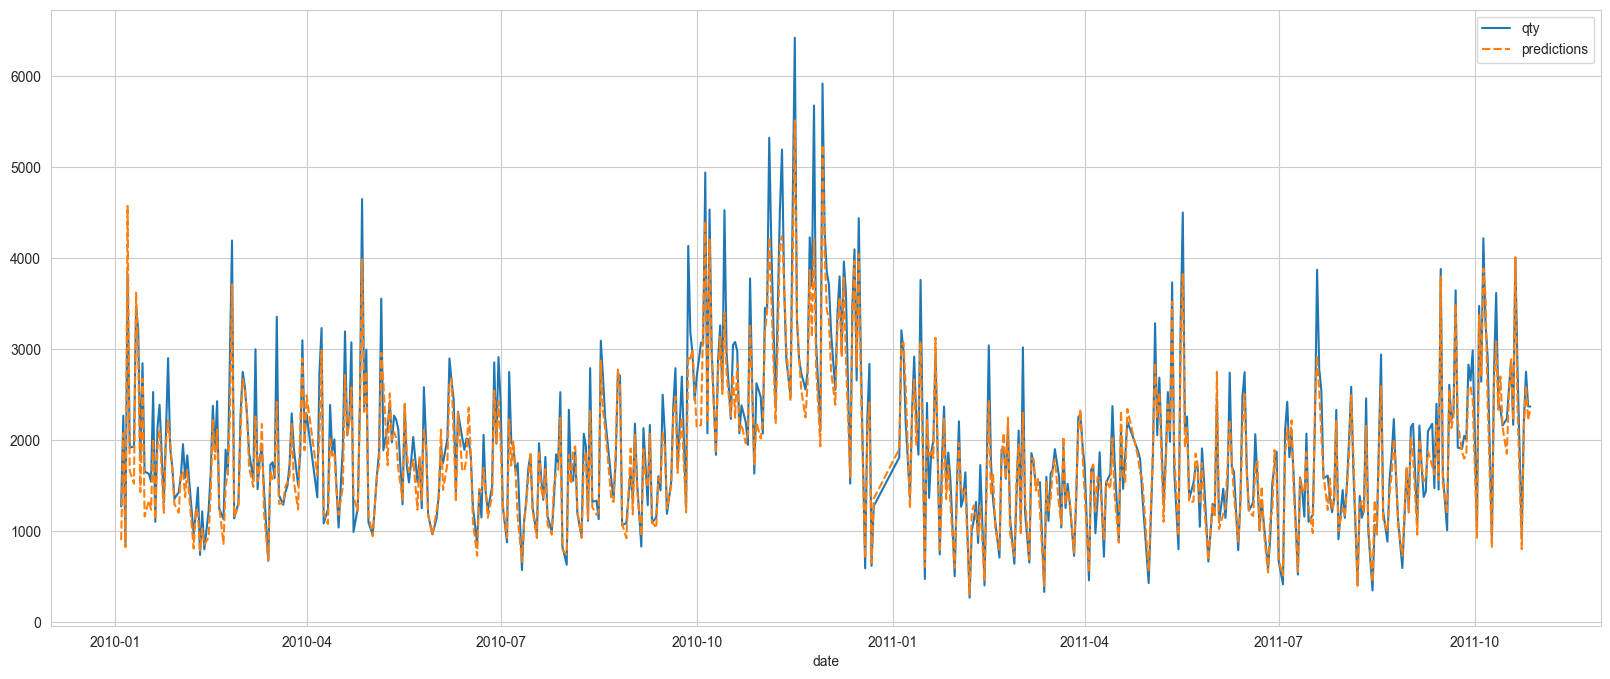

In [78]:
df_temp = df_model_train[(df_model_train['product_type'] == most_val_items)].groupby(by = 'date')[['qty','predictions']].sum()

df_temp['predictions'].sum()
df_temp['qty'].sum()
plt.figure(figsize=(20,8))
sns.lineplot(df_temp)

123618.55430545492

123486

<Figure size 2000x800 with 0 Axes>

<Axes: xlabel='date'>

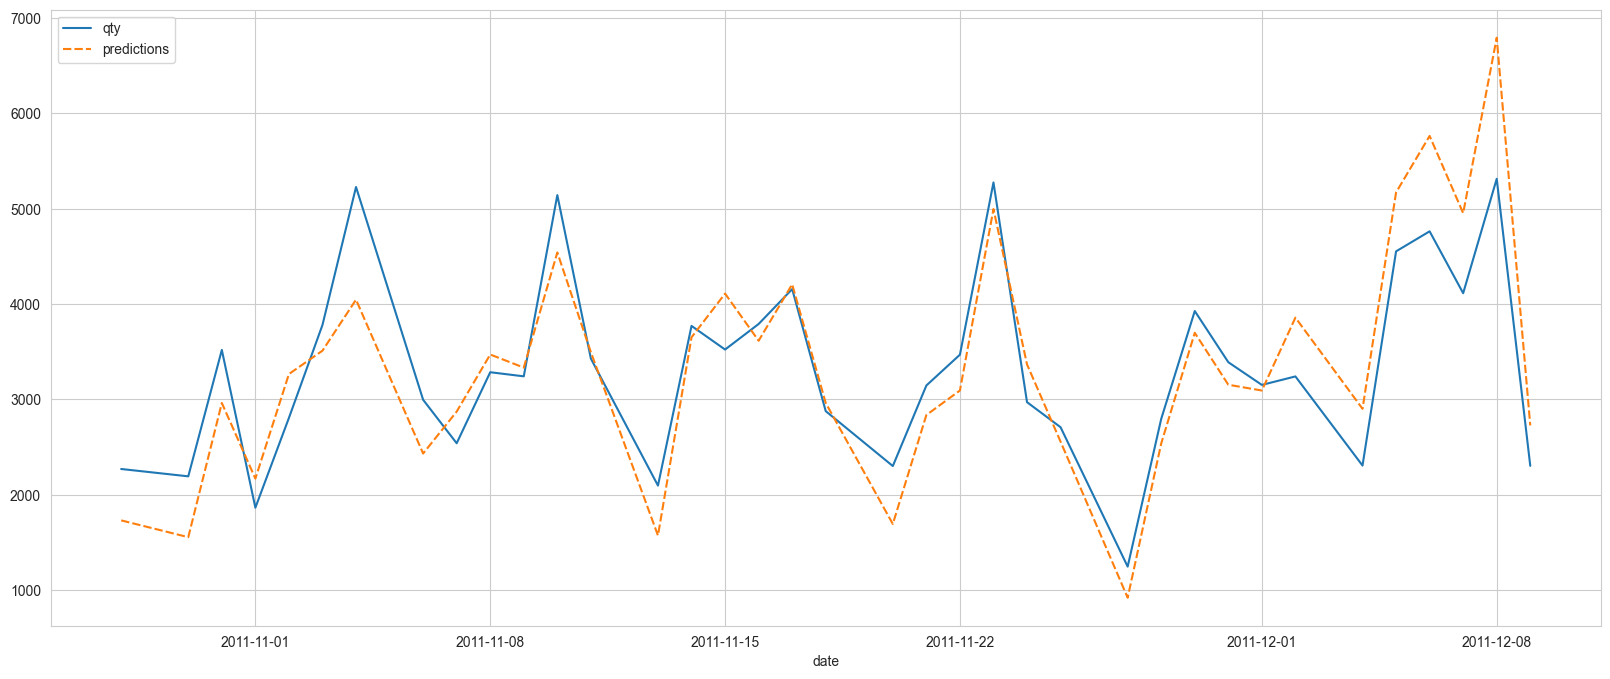

In [79]:
df_temp = df_model_test[df_model_test['product_type'] == most_val_items].groupby(by = 'date')[['qty','predictions']].sum()

df_temp['predictions'].sum()
df_temp['qty'].sum()
plt.figure(figsize=(20,8))
sns.lineplot(df_temp)

## Weekly Level Model

Due to the above analysis, we showed daily sales offers high volatility, while weekly sales are smoother. Let' create a model also for this level

Start Cleaning Process...
CLEANING INVOICE
CLEANING STOCK CODE
CLEANING DESCRIPTION
CLEANING QUANTITY
CLEANING PRICE
We dropped 141592 records

End!

Preparing data for the model...
 FEATURE ENGINEERING
For n_clusters = 2, the average silhouette score is 0.3884
For n_clusters = 3, the average silhouette score is 0.2813
For n_clusters = 4, the average silhouette score is 0.2867
For n_clusters = 5, the average silhouette score is 0.2797
For n_clusters = 6, the average silhouette score is 0.2838
For n_clusters = 7, the average silhouette score is 0.2682
For n_clusters = 8, the average silhouette score is 0.2673
For n_clusters = 9, the average silhouette score is 0.2581
For n_clusters = 10, the average silhouette score is 0.2591


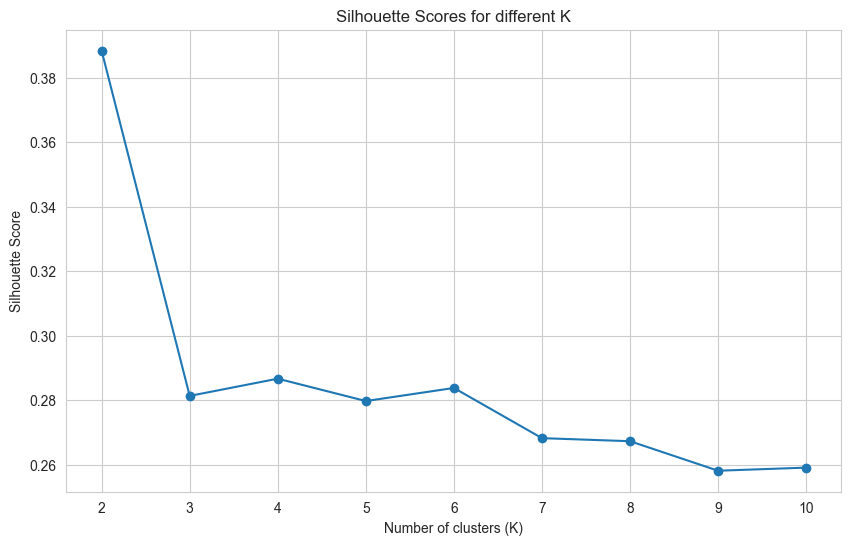


Optimal number of clusters: 2


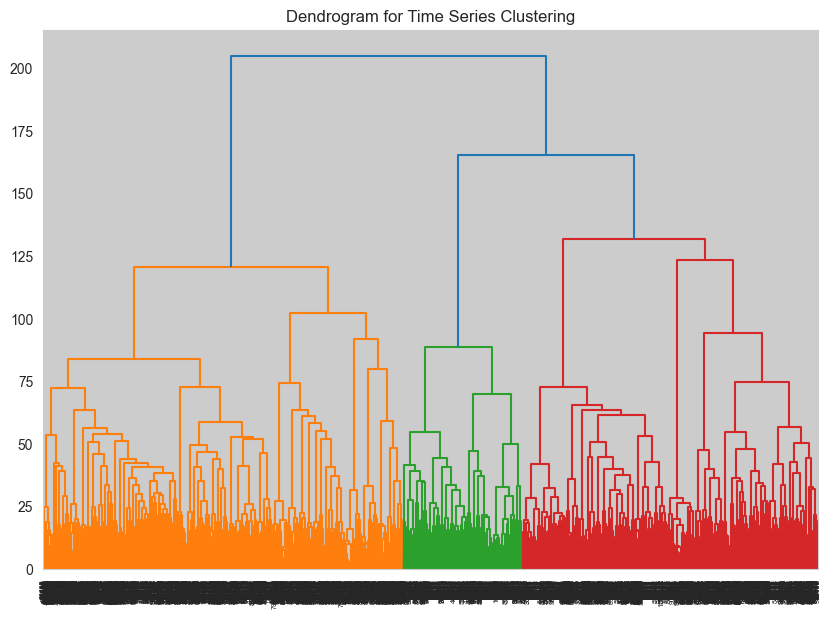

In [80]:
df_model = data_model_preparation(level = 'week')

In [81]:
try:
    X = df_model.drop(columns=['qty', 'predictions', 'year'])
except:
    X = df_model.drop(columns=['qty', 'year'])
y = df_model['qty']


params = {
    'loss': 'RMSE',
    'seed': 42,
    'iterations': 1000,
    'max_depth': 6,
    'eval_metric': 'RMSE',
    'learning_rate': 0.01
}
model = Catmodel('base', params)


days = df_model.date.max() - pd.Timedelta(days=42)
model.set_data(X,y, days)
model.learn(plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

base, early-stopped model tree count: 995


In [82]:
df_model['predictions'] = model.predict(X)

In [83]:
most_val_items = np.argmax([df_model[df_model.product_type == i]['price'].mean() for i in range(len(df_model.product_type.unique()))])

117226.0101369838

120467

<Figure size 2000x800 with 0 Axes>

<Axes: xlabel='date'>

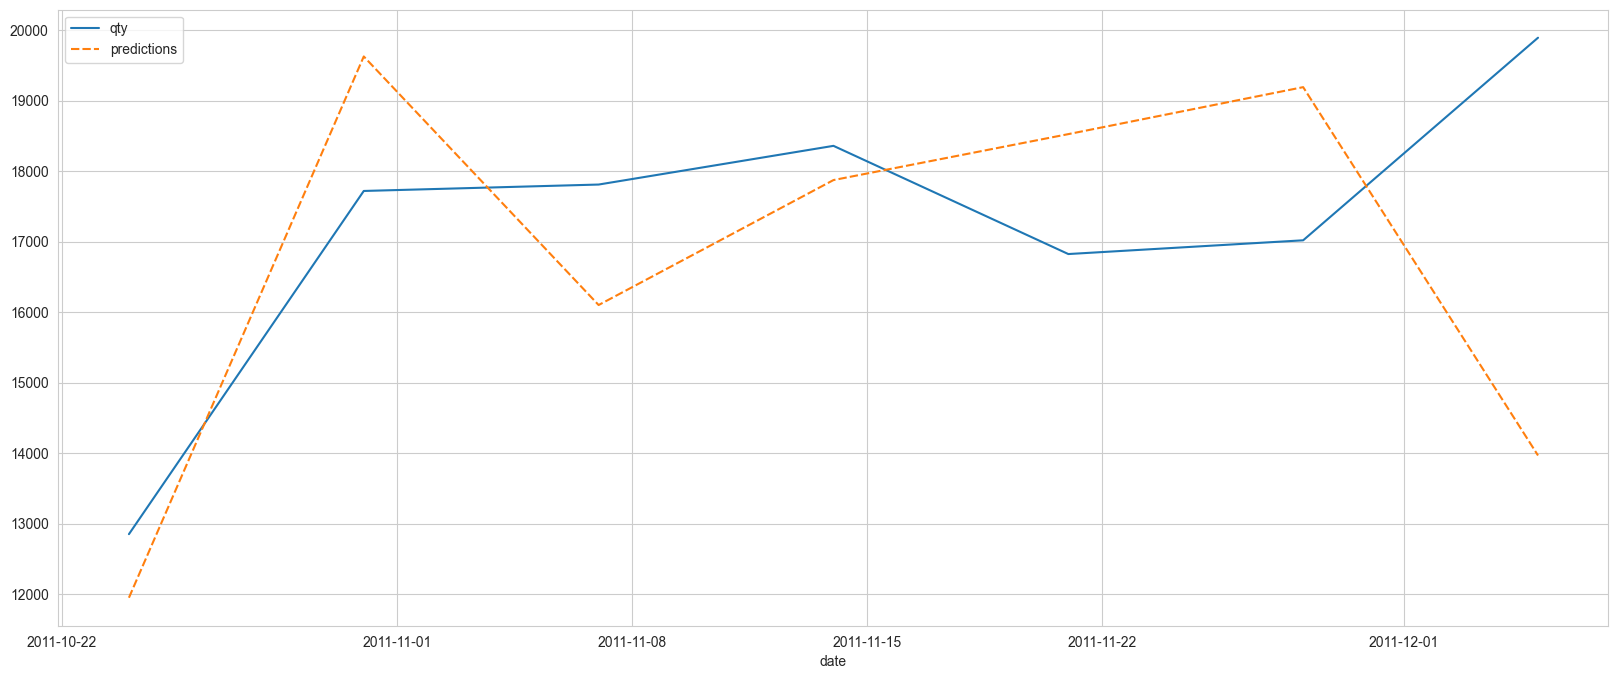

In [84]:
df_temp = df_model[(df_model['product_type'] == most_val_items) & (df_model.date >= df_model.date.max() -pd.Timedelta(days=42))].groupby(by = 'date')[['qty','predictions']].sum()

df_temp['predictions'].sum()
df_temp['qty'].sum()
plt.figure(figsize=(20,8))
sns.lineplot(df_temp)

<Figure size 2000x800 with 0 Axes>

<Axes: xlabel='date'>

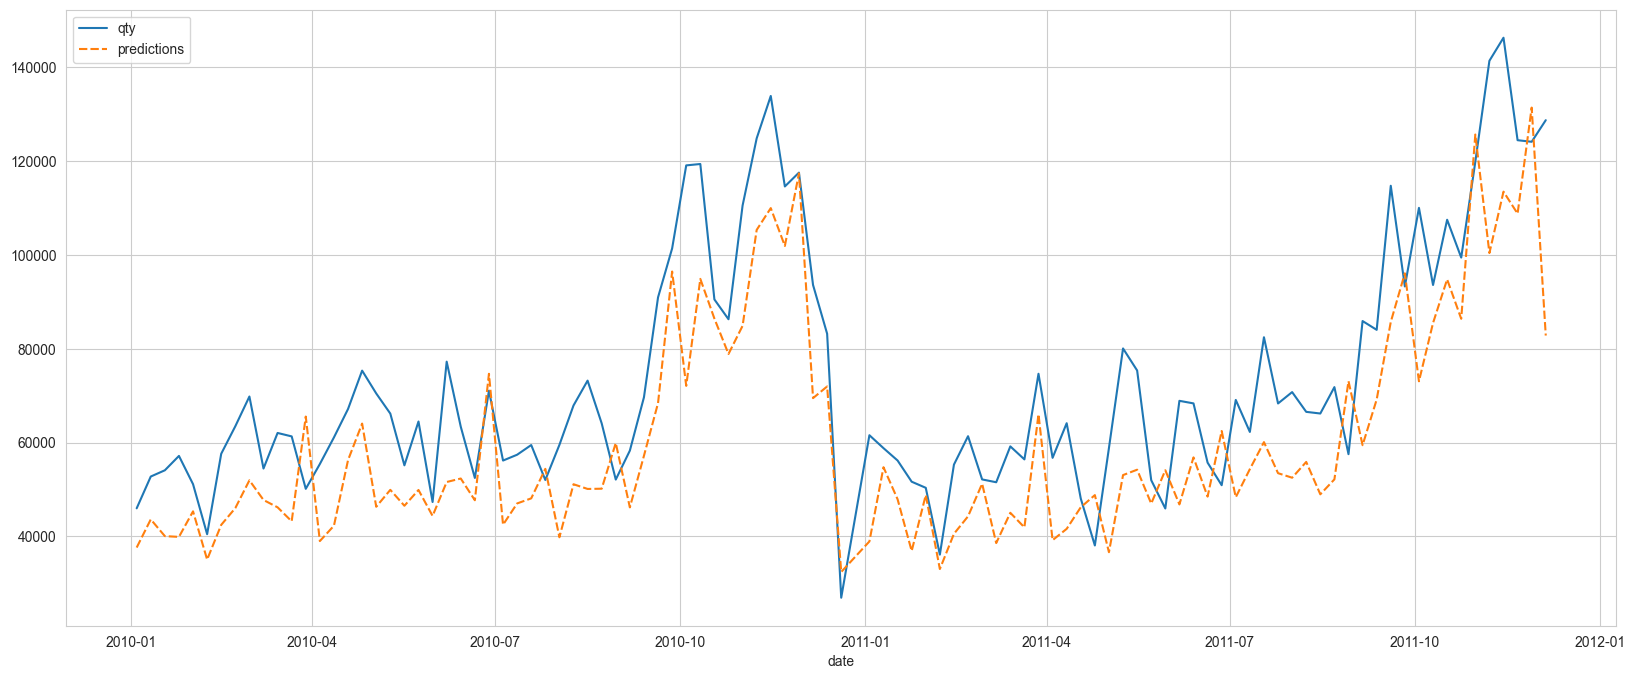

In [85]:
df_temp = df_model.groupby(by = 'date')[['qty','predictions']].sum()


plt.figure(figsize=(20,8))
sns.lineplot(df_temp)

## Results and Next Steps

The model seems to fit pretty well and it was trained by given more light to the "most valuable" items. Indeed, the predictions for this category seem to overestimate the real values. This will lead toward great pool of safety stock, preventing the out of stock. Moreover, for all the other items the model since to work pretty good. This could help the Proc Dip to better organize the supplies

However there are a lot of open points in order to improve the forecast. Here some questions to start a proficient discussion with Proc Dep.
- Why there are so many odd records in the dataset? 
- Are the outliers real outlier?
- What are the meaning of all the odd items with found?
- Are there sort of campings that could boost the data? When?

This will help us to construct a better database. Nevertheless, some extra data could help us developing a better model as well as make the current model more useful
- Available Stock: this feature will help us to know the stock status. 
- Lead Time (to warehouse): this feature will help the Proc Dep to order the items in advanced
- Proc. Cost: we know the price of selling, however we do not know the cost for the retailer to buy this stuff. This feature, toghether with a discussion with Proc Dep. could help to understand better the trade-off stock-sales
- Moreover, we could discuss about external factors: GDP of countries, others


About the model:
- We tried only one (complex) model. While this model could be understandable via shape values, it's quite a black box and maybe the Proc Dep wants to know better the decisional process of the model.
- We tried only one model. This could be used as baseline, then we can fit different models (both simpler and more complex), like linear regression, Prophet, 
- We can tried different approaches like weekly data instead of daily data; adding or reducing features

Other Analysis:
- Another fancy analysis is the RFM to understand and predict the future behavior of the customers. This can help mostly the Marketing Team to organize ad-hoc promotions


In [86]:
df_api = pd.concat([df_model_train, df_model_test])

In [88]:
df_api = df_api.groupby(by = ['stock_code', 'date'], as_index = False)[['qty', 'predictions']].sum()
df_api.to_csv(PATH_DATA_OUTPUT / "data_api.csv", index=False, sep=";")
df_api.to_csv(PATH_HOME / "stock_project/API/data_api.csv", index=False, sep=";")